In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import ticker
from matplotlib.dates import DateFormatter
from collections import Counter
import seaborn as sns
from hapiclient import hapi, hapitime2datetime

sns.set_theme()
sns.set_context("paper")
sns.set_palette("colorblind")

In [48]:
# Loading in SOPHIE Data
sophie80df = pd.read_csv("Data/SOPHIE_EPT80_1990-2022.csv", low_memory=False)
sophie80df['Date_UTC'] = pd.to_datetime(sophie80df['Date_UTC'])
sophie80df = sophie80df[sophie80df['Date_UTC'].between('1996','2022')]

array = np.zeros(len(sophie80df['Date_UTC']),dtype=int)
for i in range(4,len(sophie80df['Date_UTC'])-2):
    if (sophie80df.iloc[i-4]['Phase'] == 1) and (sophie80df.iloc[i-3]['Phase'] == 2) and (sophie80df.iloc[i-3]['Flag'] == 0) and (sophie80df.iloc[i-2]['Phase'] == 3) and (sophie80df.iloc[i-1]['Phase'] == 1) and (sophie80df.iloc[i]['Phase'] == 2) and (sophie80df.iloc[i+1]['Phase'] == 3) and (sophie80df.iloc[i+2]['Phase'] == 1) :
        array[i] = 1
        continue
    else:
        array[i] = 0
        continue

sophie80df['GERG'] = array

array = np.zeros(len(sophie80df['Date_UTC']),dtype=int)
for i in range(2,len(sophie80df['Date_UTC'])-1):
    if (sophie80df.iloc[i-2]['Phase'] == 2) and (sophie80df.iloc[i-2]['Flag'] == 0) and (sophie80df.iloc[i-1]['Phase'] == 3) and (sophie80df.iloc[i]['Phase'] == 2) and (sophie80df.iloc[i+1]['Phase'] == 3):
        array[i] = 1
        continue
    else:
        array[i] = 0
        continue

sophie80df['ERER'] = array

# choosing only sophie onsets
sophie80onsetdf = sophie80df.iloc[np.where(sophie80df['Phase']==2)]
sophie80onsetdf = sophie80onsetdf.reset_index(drop=True)
phaseafter = sophie80df['Date_UTC'].iloc[np.where(sophie80df[:-1]['Phase']==2)[0]+1].reset_index(drop=True) 
sophie80onsetdf['Duration'] = phaseafter - sophie80onsetdf['Date_UTC']
x = np.array(pd.to_timedelta(np.diff(sophie80onsetdf['Date_UTC'])))
x1 = np.insert(x,0,[pd.to_timedelta(0,'h')])
sophie80onsetdf['Waiting Time'] = x1
x2 = np.append(x,np.array([pd.to_timedelta(0,'h')],dtype=np.timedelta64))
sophie80onsetdf['Time to Next'] = x2
sophie80onsetdf['Delbay'] = pd.to_numeric(sophie80onsetdf['Delbay'],errors='coerce')

gerg = sophie80onsetdf.iloc[np.where(sophie80onsetdf['GERG']==1)]
erer = sophie80onsetdf.iloc[np.where(sophie80onsetdf['ERER']==1)]

gergnoflag = gerg.iloc[np.where(gerg['Flag']==0)]
erernoflag = erer.iloc[np.where(erer['Flag']==0)]

# Loading in SuperMAG Data
supermagdatadf = pd.read_csv('Data/SuperMAGData.csv')
supermagdatadf['Date_UTC'] = pd.to_datetime(supermagdatadf['Date_UTC'])
supermagdatadf[supermagdatadf['Date_UTC'].between('1995','2022')]
supermagdatadf['SML'].replace(999999, np.nan, inplace=True)
supermagdatadf['SMU'].replace(999999, np.nan, inplace=True)

# Loading in OMNI Data
omnidf = pd.read_csv('Data/OMNIData.csv')
omnidf['Date_UTC'] = pd.to_datetime(omnidf['Date_UTC'])
omnidf = omnidf[omnidf['Date_UTC'].between('1995','2022')]

In [49]:
# Finding the indices of the first and last sophie onsets in a gerg
x = np.where(sophie80onsetdf['GERG']==1)[0]
y = np.where(sophie80onsetdf['Flag']==0)[0]
z = np.intersect1d(x,y)
a = z - 1
b = np.setdiff1d(a,z)
c = np.intersect1d(b,y)
firstgerg = sophie80onsetdf.iloc[c]
lastgerg = sophie80onsetdf.iloc[np.setdiff1d(z,a)]

# # Finding the indices of the first and last sophie onsets in a erer
x = np.where(sophie80onsetdf['ERER']==1)[0]
y = np.where(sophie80onsetdf['Flag']==0)[0]
z = np.intersect1d(x,y)
a = z - 1
b = np.setdiff1d(a,z)
c = np.intersect1d(b,y)
firster = sophie80onsetdf.iloc[c]
laster = sophie80onsetdf.iloc[np.setdiff1d(z,a)]


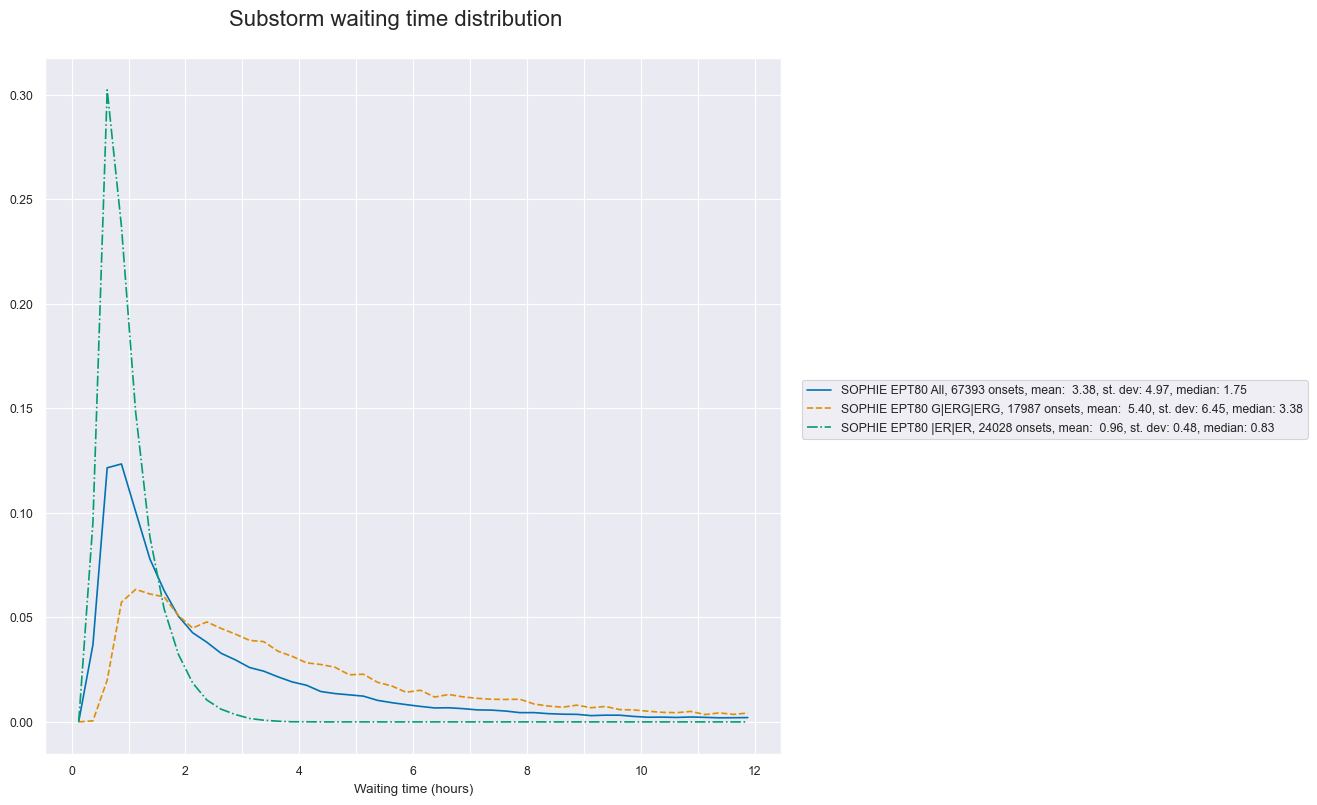

In [50]:
def waitingtime_hist(array):
    x, y = np.histogram(array['Waiting Time']/pd.to_timedelta(1,'h'),bins=np.arange(0,12.25,.25))
    y = y+.125
    y = y[:-1]
    d = {'Waiting Time':y,'Density':x/np.sum(x)}
    df = pd.DataFrame(d)
    return df


onsetlists = [sophie80onsetdf, gergnoflag, erernoflag]
labels = ['SOPHIE EPT80 All', 'SOPHIE EPT80 G|ERG|ERG','SOPHIE EPT80 |ER|ER']
onsetnumbers = [len(i) for i in onsetlists]
onsetnumbers[1] += len(firstgerg)
onsetnumbers[2] += len(firster)
means = [np.mean(i['Waiting Time'])/pd.Timedelta(1,'h') for i in onsetlists]
stdevs = [np.std(i['Waiting Time'])/pd.Timedelta(1,'h') for i in onsetlists]
medians = [np.median(i['Waiting Time'])/pd.Timedelta(1,'h') for i in onsetlists]
labels = ["{}, {} onsets, mean:  {:.2f}, st. dev: {:.2f}, median: {:.2f}".format(labels[i],onsetnumbers[i],means[i],stdevs[i],medians[i]) for i in range(len(onsetlists))]

lines = ['solid','dashed','dashdot']
wts = [waitingtime_hist(i) for i in onsetlists]
fig, axes = plt.subplots(figsize=(8,8))

for i in range(len(onsetlists)):
    axes.plot(wts[i]['Waiting Time'],wts[i]['Density'], label=labels[i], ls=lines[i])
    
axes.xaxis.set_minor_locator(ticker.MultipleLocator(1))
axes.set_xlabel('Waiting time (hours)')
axes.grid(True,'both')
fig.suptitle('Substorm waiting time distribution', fontsize=16, y=1)
fig.legend(bbox_to_anchor=(1, .5), loc='center left')
fig.tight_layout()

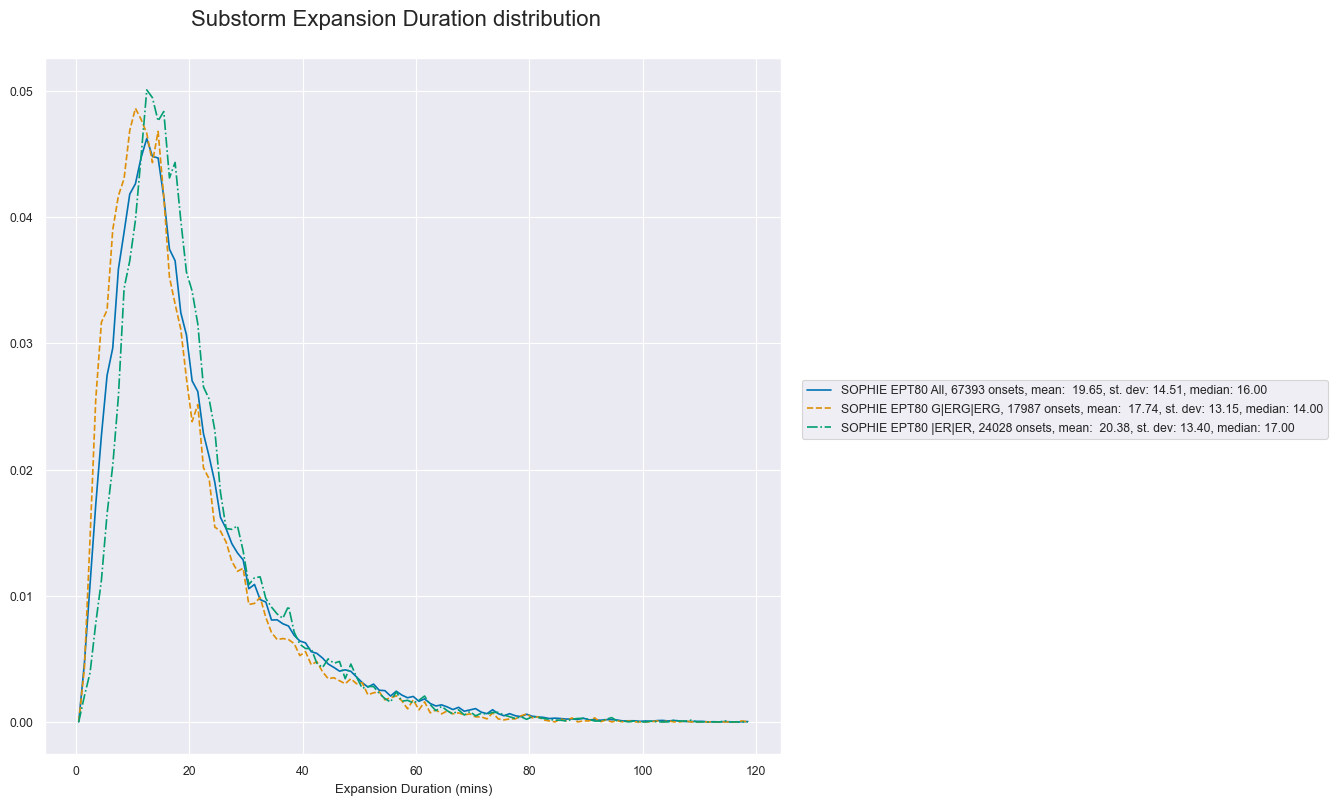

In [51]:
def duration_hist(array):
    x, y = np.histogram(array['Duration']/pd.to_timedelta(1,'m'),bins=np.arange(0,120,1))
    y = y+.5
    y = y[:-1]
    d = {'Duration':y,'Density':x/np.sum(x)}
    df = pd.DataFrame(d)
    return df

onsetlists = [sophie80onsetdf, gergnoflag, erernoflag]
labels = ['SOPHIE EPT80 All', 'SOPHIE EPT80 G|ERG|ERG','SOPHIE EPT80 |ER|ER']
onsetnumbers = [len(i) for i in onsetlists]
onsetnumbers[1] += len(firstgerg)
onsetnumbers[2] += len(firster)
means = [np.mean(i['Duration'])/pd.Timedelta(1,'m') for i in onsetlists]
stdevs = [np.std(i['Duration'])/pd.Timedelta(1,'m') for i in onsetlists]
medians = [np.median(i['Duration'])/pd.Timedelta(1,'m') for i in onsetlists]
labels = ["{}, {} onsets, mean:  {:.2f}, st. dev: {:.2f}, median: {:.2f}".format(labels[i],onsetnumbers[i],means[i],stdevs[i],medians[i]) for i in range(len(onsetlists))]

lines = ['solid','dashed','dashdot']
wts = [duration_hist(i) for i in onsetlists]
fig, axes = plt.subplots(figsize=(8,8))

for i in range(len(onsetlists)):
    axes.plot(wts[i]['Duration'],wts[i]['Density'], label=labels[i], ls=lines[i])
    

axes.set_xlabel('Expansion Duration (mins)')
axes.grid(True,'both')
fig.suptitle('Substorm Expansion Duration distribution', fontsize=16, y=1)
fig.legend(bbox_to_anchor=(1, .5), loc='center left')
fig.tight_layout()

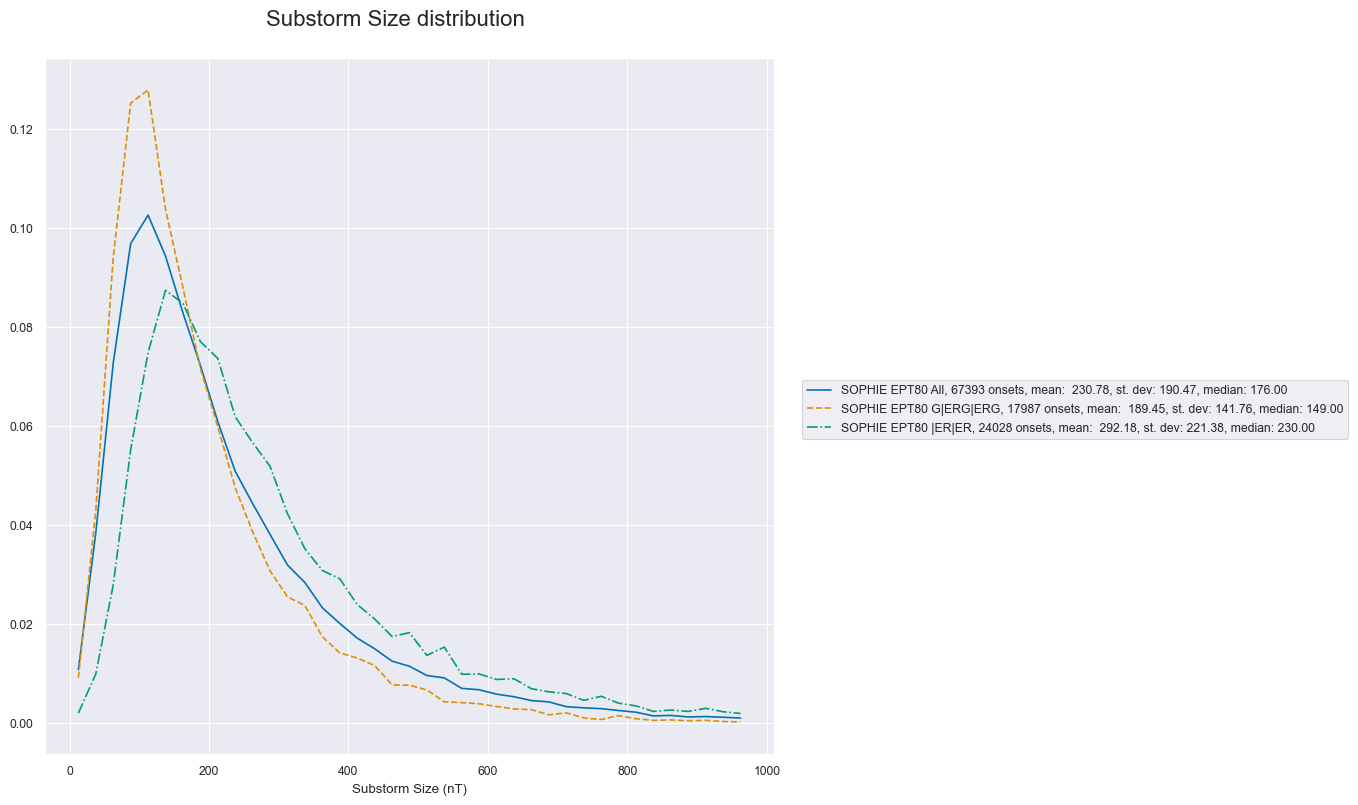

In [52]:
def size_hist(array):
    x, y = np.histogram(-array['Delbay'],bins=np.arange(0,1000,25))
    y = y + 12.5
    y = y[:-1]
    d = {'Size':y,'Density':x/np.sum(x)}
    df = pd.DataFrame(d)
    return df

onsetlists = [sophie80onsetdf, gergnoflag, erernoflag]
labels = ['SOPHIE EPT80 All', 'SOPHIE EPT80 G|ERG|ERG','SOPHIE EPT80 |ER|ER']
onsetnumbers = [len(i) for i in onsetlists]
onsetnumbers[1] += len(firstgerg)
onsetnumbers[2] += len(firster)
means = [np.nanmean(-i['Delbay']) for i in onsetlists]
stdevs = [np.nanstd(-i['Delbay']) for i in onsetlists]
medians = [np.nanmedian(-i['Delbay']) for i in onsetlists]
labels = ["{}, {} onsets, mean:  {:.2f}, st. dev: {:.2f}, median: {:.2f}".format(labels[i],onsetnumbers[i],means[i],stdevs[i],medians[i]) for i in range(len(onsetlists))]

lines = ['solid','dashed','dashdot']
wts = [size_hist(i) for i in onsetlists]
fig, axes = plt.subplots(figsize=(8,8))

for i in range(len(onsetlists)):
    axes.plot(wts[i]['Size'],wts[i]['Density'], label=labels[i],ls=lines[i])
    
axes.set_xlabel('Substorm Size (nT)')
axes.grid(True,'both')
fig.suptitle('Substorm Size distribution', fontsize=16, y=1)
fig.legend(bbox_to_anchor=(1, .5), loc='center left')
fig.tight_layout()

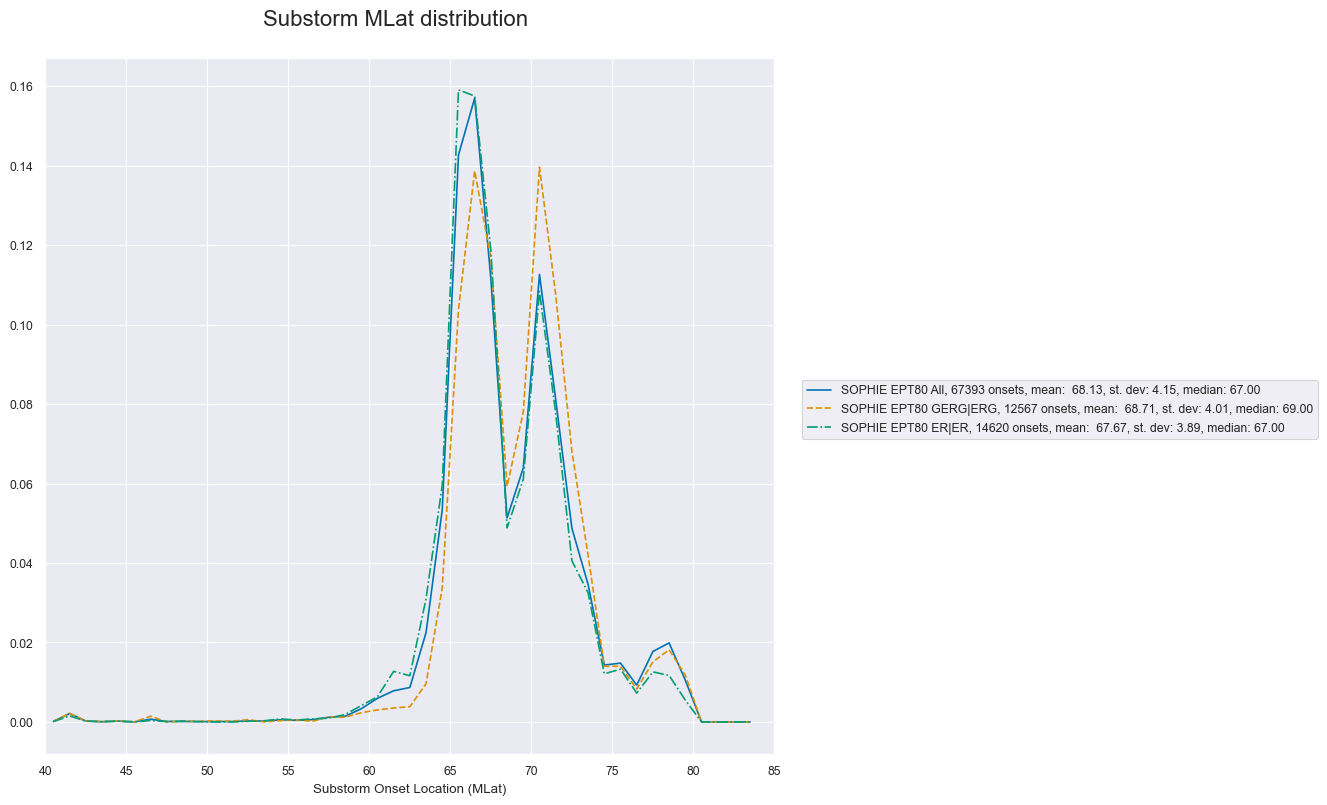

In [53]:
def mlat_hist(array):
    x, y = np.histogram(array['MLat'],bins=np.arange(40,85,1))
    y = y + .5
    y = y[:-1]
    d = {'MLat':y,'Density':x/np.sum(x)}
    df = pd.DataFrame(d)
    return df

onsetlists = [sophie80onsetdf, gergnoflag, erernoflag]
labels = ['SOPHIE EPT80 All', 'SOPHIE EPT80 GERG|ERG','SOPHIE EPT80 ER|ER']
onsetnumbers = [len(i) for i in onsetlists]
means = [np.mean(i['MLat']) for i in onsetlists]
stdevs = [np.std(i['MLat']) for i in onsetlists]
medians = [np.median(i['MLat']) for i in onsetlists]
labels = ["{}, {} onsets, mean:  {:.2f}, st. dev: {:.2f}, median: {:.2f}".format(labels[i],onsetnumbers[i],means[i],stdevs[i],medians[i]) for i in range(len(onsetlists))]

lines = ['solid','dashed','dashdot']
wts = [mlat_hist(i) for i in onsetlists]
fig, axes = plt.subplots(figsize=(8,8))

for i in range(len(onsetlists)):
    axes.plot(wts[i]['MLat'],wts[i]['Density'], label=labels[i],ls=lines[i])
    

axes.set_xlim(40,85)
axes.set_xlabel('Substorm Onset Location (MLat)')
axes.grid(True,'both')
fig.suptitle('Substorm MLat distribution', fontsize=16, y=1)
fig.legend(bbox_to_anchor=(1, .5), loc='center left')
fig.tight_layout()


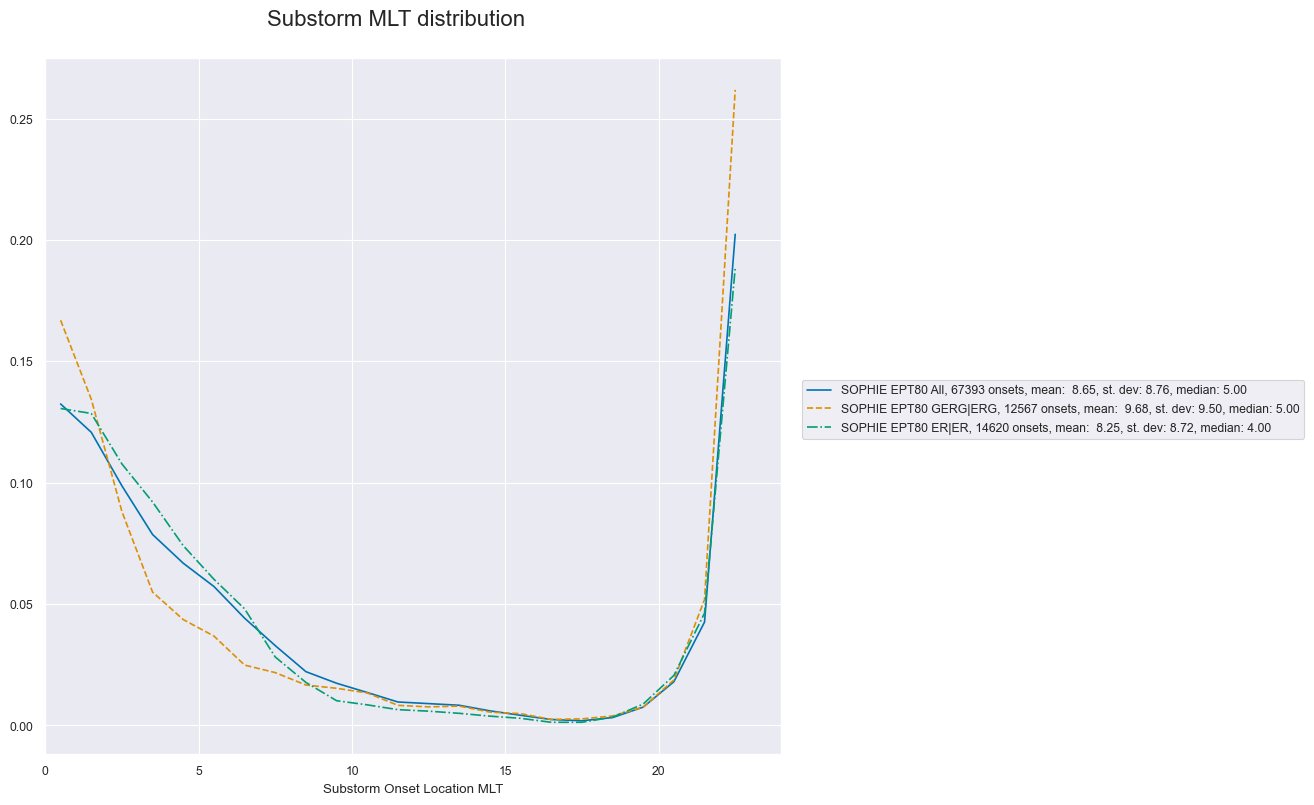

In [54]:
def mlt_hist(array):
    x, y = np.histogram(array['MLT'],bins=np.arange(0,24,))
    y = y + .5
    y = y[:-1]
    d = {'MLT':y,'Density':x/np.sum(x)}
    df = pd.DataFrame(d)
    return df

onsetlists = [sophie80onsetdf, gergnoflag, erernoflag]
labels = ['SOPHIE EPT80 All', 'SOPHIE EPT80 GERG|ERG','SOPHIE EPT80 ER|ER']
onsetnumbers = [len(i) for i in onsetlists]
means = [np.mean(i['MLT']) for i in onsetlists]
stdevs = [np.std(i['MLT']) for i in onsetlists]
medians = [np.median(i['MLT']) for i in onsetlists]
labels = ["{}, {} onsets, mean:  {:.2f}, st. dev: {:.2f}, median: {:.2f}".format(labels[i],onsetnumbers[i],means[i],stdevs[i],medians[i]) for i in range(len(onsetlists))]

lines = ['solid','dashed','dashdot']
wts = [mlt_hist(i) for i in onsetlists]
fig, axes = plt.subplots(figsize=(8,8))

for i in range(len(onsetlists)):
    axes.plot(wts[i]['MLT'],wts[i]['Density'], label=labels[i],ls=lines[i])
    

axes.set_xlim(0,24)
axes.set_xlabel('Substorm Onset Location MLT')
axes.grid(True,'both')
fig.suptitle('Substorm MLT distribution', fontsize=16, y=1)
fig.legend(bbox_to_anchor=(1, .5), loc='center left')
fig.tight_layout()


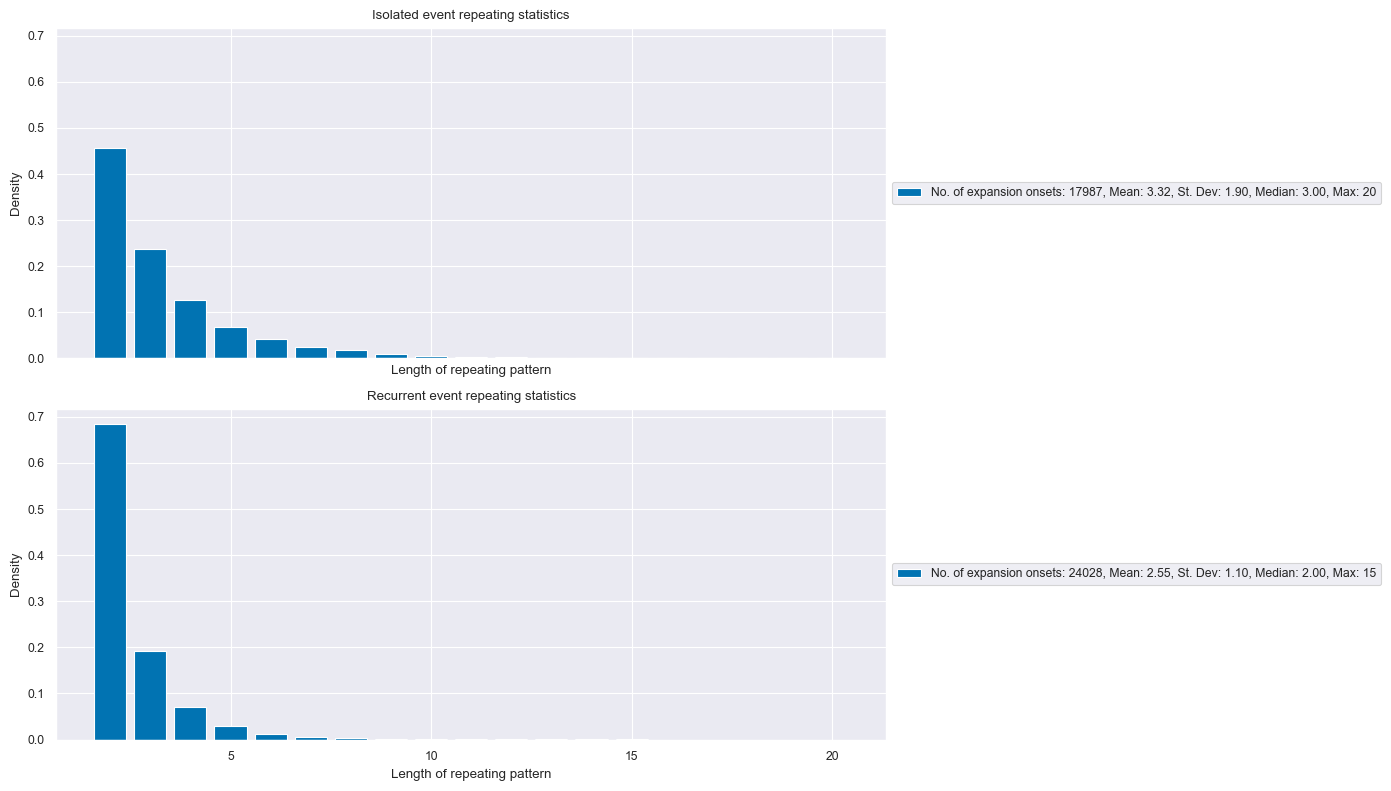

In [55]:
# Plotting chain lengths
x = np.where(sophie80onsetdf['GERG']==1)[0]
y = np.where(sophie80onsetdf['Flag']==0)[0]
s = np.zeros(len(sophie80onsetdf))
s[np.intersect1d(x,y)] = True
s = pd.Series(s.astype(bool))
co = (~s).cumsum()[s].value_counts().to_list()
co = [i+1 for i in co]
label = 'No. of expansion onsets: {}, Mean: {:.2f}, St. Dev: {:.2f}, Median: {:.2f}, Max: {}'.format(len(gergnoflag)+len(firstgerg),np.mean(co), np.std(co), np.median(co), np.max(co))
y, x = np.histogram(co, bins=np.arange(2,np.max(co)+2,1),density=True)
x = x[:-1]


fig, (ax, ax1) = plt.subplots(2,1, figsize=(14,8),sharex=True, sharey=True)

ax.bar(x,y,label=label)
ax.set_xlabel('Length of repeating pattern')
ax.set_ylabel('Density')
ax.set_title("Isolated event repeating statistics")
ax.legend(bbox_to_anchor=(1, .5), loc='center left')
ax.xaxis.set_tick_params(labelbottom=True)

x = np.where(sophie80onsetdf['ERER']==1)[0]
y = np.where(sophie80onsetdf['Flag']==0)[0]
s = np.zeros(len(sophie80onsetdf))
s[np.intersect1d(x,y)] = True
s = pd.Series(s.astype(bool))
co = (~s).cumsum()[s].value_counts().to_list()
co = [i+1 for i in co]
label = 'No. of expansion onsets: {}, Mean: {:.2f}, St. Dev: {:.2f}, Median: {:.2f}, Max: {}'.format(len(erernoflag)+len(firster),np.mean(co), np.std(co), np.median(co), np.max(co))
y, x = np.histogram(co, bins=np.arange(2,np.max(co)+2,1),density=True)
x = x[:-1]

ax1.bar(x,y,label=label)
ax1.set_xlabel('Length of repeating pattern')
ax1.set_ylabel('Density')
ax1.set_title("Recurrent event repeating statistics")
ax1.legend(bbox_to_anchor=(1, .5), loc='center left')
ax1.xaxis.set_major_locator(ticker.MultipleLocator(2))
fig.tight_layout()


[(2, 2477), (3, 1286), (4, 691), (5, 364), (6, 230), (7, 131), (8, 101), (9, 54), (10, 31), (11, 21), (12, 16), (13, 8), (14, 1), (15, 4), (16, 0), (17, 3), (18, 1), (19, 0), (20, 1)]


Text(0.5, 1.05, 'Isolated event repeating statistics')

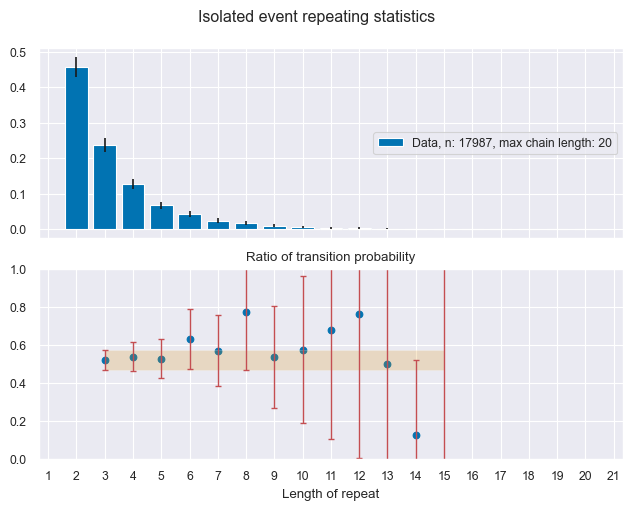

In [56]:
# Analysis of gerg chain lengths
x = np.where(sophie80onsetdf['GERG']==1)[0]
y = np.where(sophie80onsetdf['Flag']==0)[0]
indices_onsets =np.intersect1d(x,y)
s = np.zeros(len(sophie80onsetdf))
s[indices_onsets] = True
s = pd.Series(s.astype(bool))
co = (~s).cumsum()[s].value_counts().to_list()
co = [i+1 for i in co]

y, x = np.histogram(co, bins=np.arange(2,np.max(co)+2,1))
x = x[:-1]
yerror = [np.sqrt(i) for i in y]
print(list(zip(x,y)))
if np.where(y==0)[0].size > 0:
    yanalysis = y[:np.where(y==0)[0][0]]
else:
    yanalysis = y


yerror = yerror/np.sum(y)
yerror = 3*yerror
y = y/np.sum(y)
yanalysis = yanalysis/sum(yanalysis)

ratio = np.array([yanalysis[i]/yanalysis[i-1] for i in range(1,len(yanalysis))])
ratioerror = np.array([np.sqrt((yerror[i]/yanalysis[i])**2 + (yerror[i-1]/yanalysis[i-1])**2) for i in range(1,len(yanalysis))])
ratioerror = ratioerror*ratio

fig, (ax, ax1) = plt.subplots(2,1,sharex=True)

ax.bar(x,y,yerr=yerror,label='Data, n: {}, max chain length: {}'.format(len(indices_onsets)+len(firstgerg),np.max(co)))
ax.legend(loc='center right')

ax1.scatter(x[:len(ratio)]+1, ratio[:len(ratio)])
ax1.errorbar(x[:len(ratio)]+1, ratio[:len(ratio)], yerr=ratioerror, fmt='none', ecolor='r', elinewidth=1, capsize=2)
ax1.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax1.set_xlabel("Length of repeat")
ax1.set_title("Ratio of transition probability")
ax1.set_ylim(0,1)

ax1.fill_between(x[:len(ratio)]+1, ratio[0]-ratioerror[0], ratio[0]+ratioerror[0], alpha=0.2)

fig.tight_layout(pad=1)
fig.suptitle('Isolated event repeating statistics',y=1.05)



[(2, 6427), (3, 1803), (4, 665), (5, 270), (6, 117), (7, 54), (8, 27), (9, 20), (10, 11), (11, 5), (12, 6), (13, 1), (14, 1), (15, 1)]


Text(0.5, 1.05, 'Recurrent event repeating statistics')

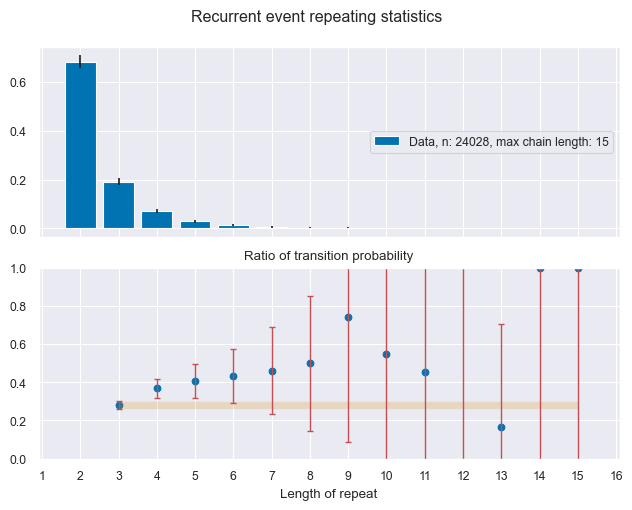

In [57]:
# Analysis of erer chain lengths
x = np.where(sophie80onsetdf['ERER']==1)[0]
y = np.where(sophie80onsetdf['Flag']==0)[0]
indices_onsets =np.intersect1d(x,y)
s = np.zeros(len(sophie80onsetdf))
s[indices_onsets] = True
s = pd.Series(s.astype(bool))
co = (~s).cumsum()[s].value_counts().to_list()
co = [i+1 for i in co]
y, x = np.histogram(co, bins=np.arange(2,np.max(co)+2,1))
x = x[:-1]
print(list(zip(x,y)))
yerror = [np.sqrt(i) for i in y]
if np.where(y==0)[0].size > 0:
    yanalysis = y[:np.where(y==0)[0][0]]
else:
    yanalysis = y

yerror = yerror/np.sum(y)
yerror = 3*yerror
y = y/np.sum(y)
yanalysis = yanalysis/sum(yanalysis)


ratio = np.array([yanalysis[i]/yanalysis[i-1] for i in range(1,len(yanalysis))])
ratioerror = np.array([np.sqrt((yerror[i]/yanalysis[i])**2 + (yerror[i-1]/yanalysis[i-1])**2) for i in range(1,len(yanalysis))])
ratioerror = ratioerror*ratio

fig, (ax, ax1) = plt.subplots(2,1,sharex=True)

ax.bar(x,y,yerr=yerror,label='Data, n: {}, max chain length: {}'.format(len(indices_onsets)+len(firster),np.max(co)))
ax.legend(loc='center right')

ax1.scatter(x[:len(ratio)]+1, ratio[:len(ratio)])
ax1.errorbar(x[:len(ratio)]+1, ratio[:len(ratio)], yerr=ratioerror, fmt='none', ecolor='r', elinewidth=1, capsize=2)
ax1.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax1.set_xlabel("Length of repeat")
ax1.set_title("Ratio of transition probability")
ax1.set_ylim(0,1)

ax1.fill_between(x[:len(ratio)]+1, ratio[0]-ratioerror[0], ratio[0]+ratioerror[0], alpha=0.2)

fig.tight_layout(pad=1)
fig.suptitle("Recurrent event repeating statistics", y=1.05)

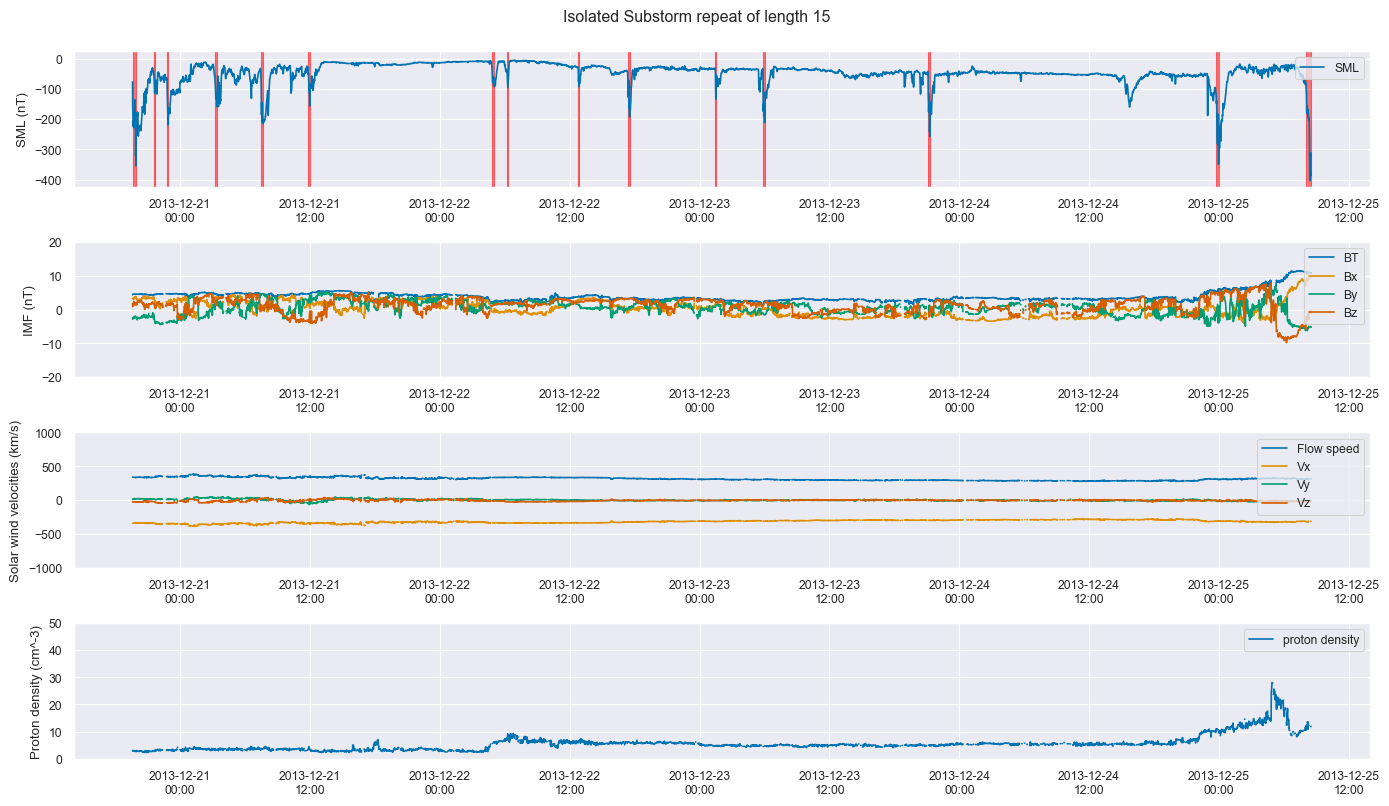

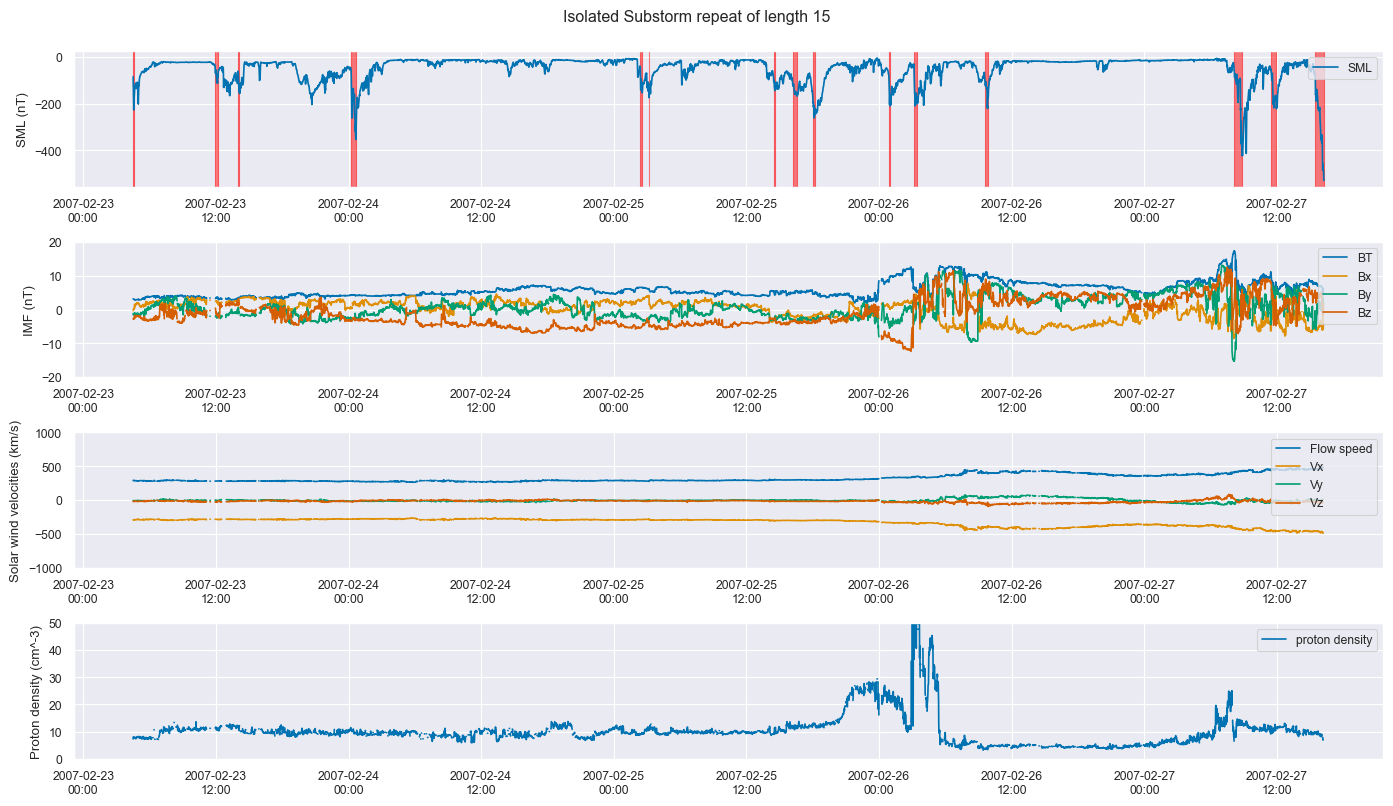

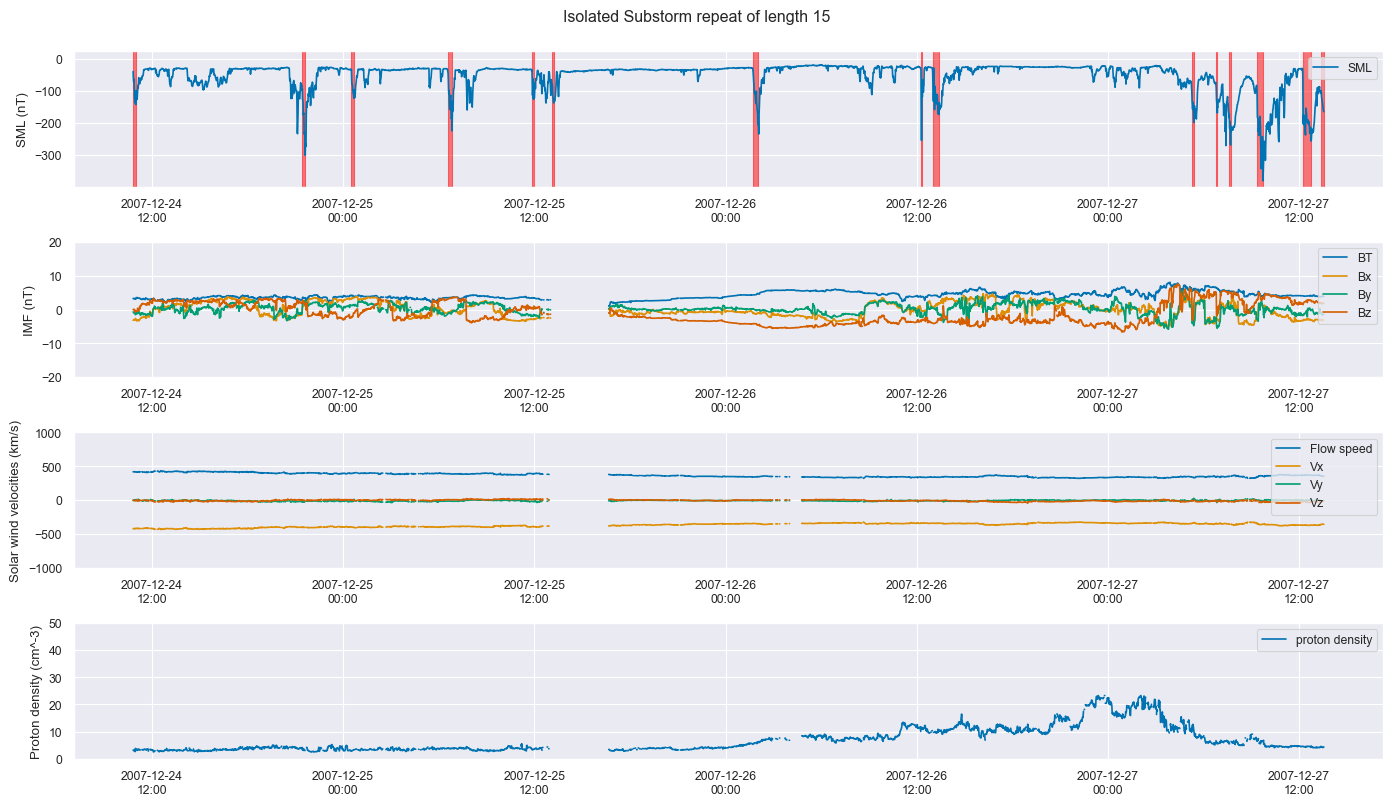

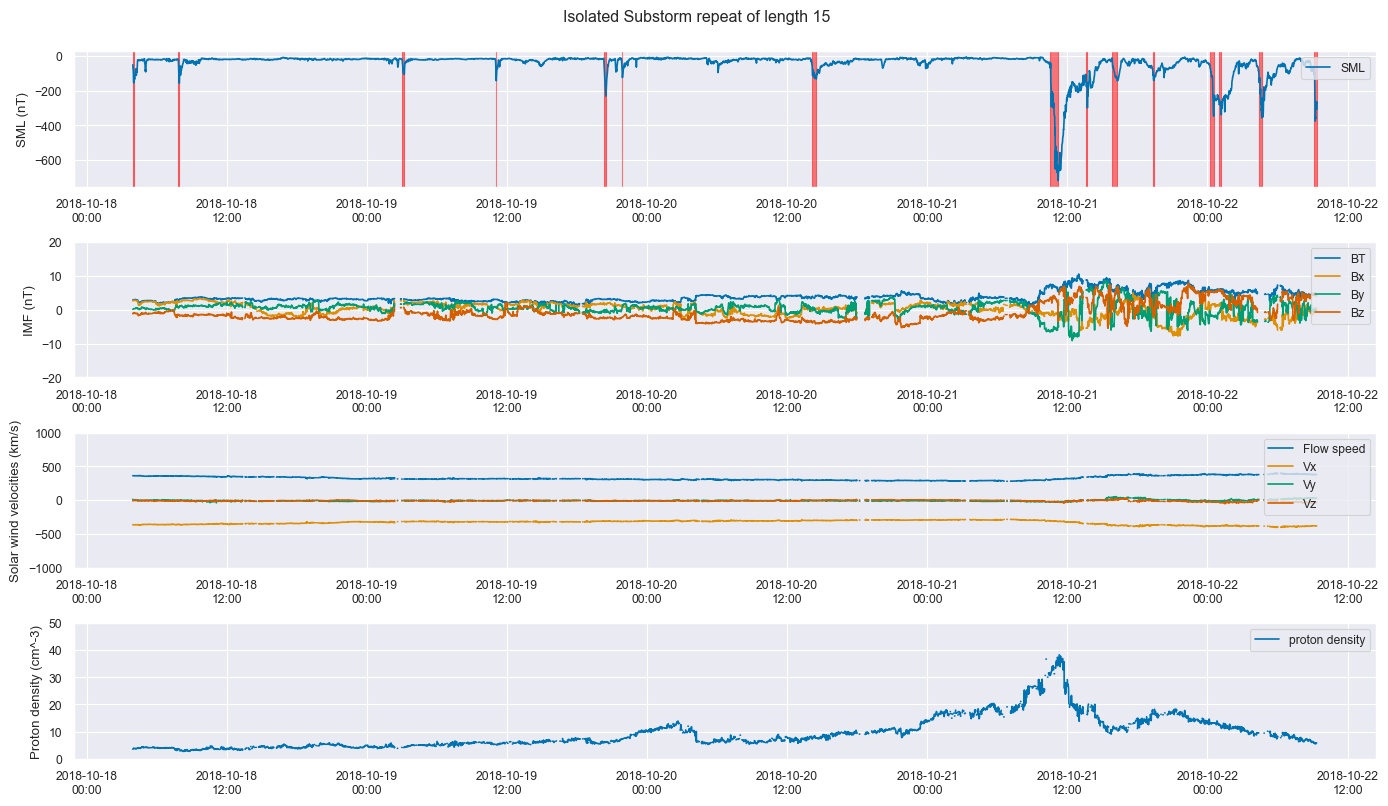

In [58]:
# Plotting various parameters of specific gerg chain lengths
x = np.where(sophie80onsetdf['GERG']==1)[0]
y = np.where(sophie80onsetdf['Flag']==0)[0]
indices_onsets =np.intersect1d(x,y)
s = np.zeros(len(sophie80onsetdf))
s[indices_onsets] = True
s = pd.Series(s.astype(bool))

len_repeat = 15

index_repeat = np.where(((~s).cumsum()[s].value_counts()+1)==len_repeat)[0]

for i in index_repeat:
    start = np.where((~s).cumsum()[s]==(~s).cumsum()[s].value_counts().index[i])[0][0]    
    stop = start + (len_repeat - 1)
    sophieindicesstart = (~s).cumsum()[s][start:stop].index[0]
    sophieindicesstop = (~s).cumsum()[s][start:stop].index[-1] + 1
    onsetslice = sophie80onsetdf.iloc[sophieindicesstart-1:sophieindicesstop]
    tstart = onsetslice['Date_UTC'][onsetslice.index[0]]
    tend = onsetslice['Date_UTC'][onsetslice.index[-1]]+onsetslice['Duration'][onsetslice.index[-1]]
    supermagslice = supermagdatadf[supermagdatadf['Date_UTC'].between(tstart,tend)]
    omnislice = omnidf[omnidf['Date_UTC'].between(tstart,tend)]

    fig, (ax, ax1, ax2, ax3) = plt.subplots(4,1,figsize=(14,8),sharex=True)
    
    ax.plot(supermagslice['Date_UTC'], supermagslice['SML'], label='SML')
    ax.set_ylabel('SML (nT)')
    date_form = DateFormatter("%Y-%m-%d\n%H:%M")
    ax.xaxis.set_major_formatter(date_form)
    ax.legend(loc='upper right') 
    ax.set_ylim(top=25)
    ax.xaxis.set_tick_params(labelbottom=True)

    for j in range(len(onsetslice)):
        ax.axvspan(onsetslice['Date_UTC'][onsetslice.index[j]], onsetslice['Date_UTC'][onsetslice.index[j]]+onsetslice['Duration'][onsetslice.index[j]], alpha=0.5, color='red')
    
    ax1.plot(omnislice['Date_UTC'],omnislice['F'],label='BT')
    ax1.plot(omnislice['Date_UTC'],omnislice['BX_GSE'],label='Bx')
    ax1.plot(omnislice['Date_UTC'],omnislice['BZ_GSM'],label='By')
    ax1.plot(omnislice['Date_UTC'],omnislice['BY_GSM'],label='Bz')
    ax1.set_ylabel('IMF (nT)')
    ax1.xaxis.set_major_formatter(date_form)
    ax1.legend(loc='upper right')
    ax1.set_ylim(-20,20)
    ax1.xaxis.set_tick_params(labelbottom=True)


    ax2.plot(omnislice['Date_UTC'],omnislice['flow_speed'],label='Flow speed')
    ax2.plot(omnislice['Date_UTC'],omnislice['Vx'],label='Vx')
    ax2.plot(omnislice['Date_UTC'],omnislice['Vy'],label='Vy')
    ax2.plot(omnislice['Date_UTC'],omnislice['Vz'],label='Vz')
    ax2.set_ylabel('Solar wind velocities (km/s)')
    ax2.xaxis.set_major_formatter(date_form)
    ax2.legend(loc='upper right')
    ax2.set_ylim(-1000,1000)
    ax2.xaxis.set_tick_params(labelbottom=True)

    ax3.plot(omnislice['Date_UTC'],omnislice['proton_density'],label='proton density')
    ax3.set_ylabel('Proton density (cm^-3)')
    ax3.xaxis.set_major_formatter(date_form)
    ax3.legend(loc='upper right')
    ax3.set_ylim(0,50)
    fig.suptitle('Isolated Substorm repeat of length {}'.format(len_repeat),y=1)

    plt.tight_layout(pad=1)

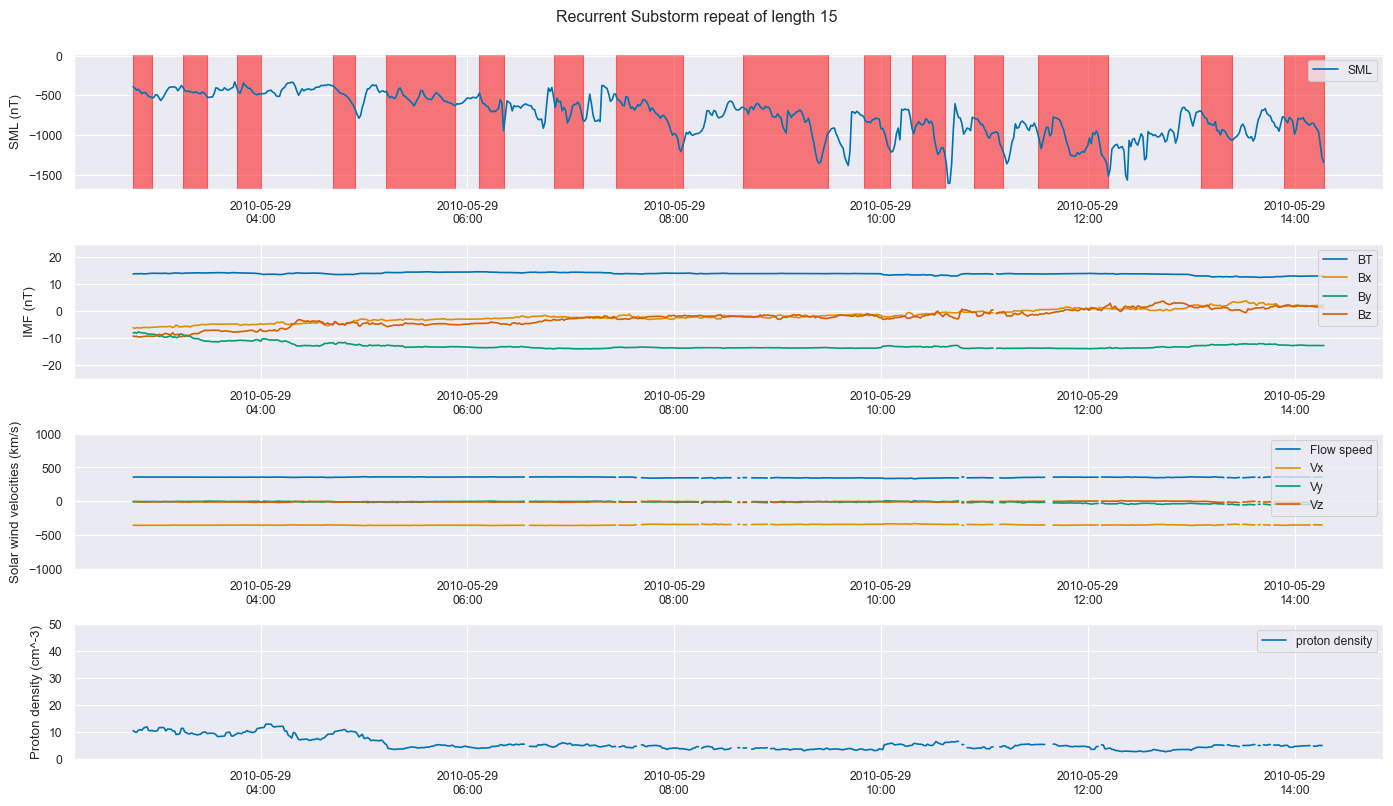

In [59]:
# Plotting various parameters for specific erer chain lengths
x = np.where(sophie80onsetdf['ERER']==1)[0]
y = np.where(sophie80onsetdf['Flag']==0)[0]
indices_onsets =np.intersect1d(x,y)
s = np.zeros(len(sophie80onsetdf))
s[indices_onsets] = True
s = pd.Series(s.astype(bool))

len_repeat = 15

index_repeat = np.where(((~s).cumsum()[s].value_counts()+1)==len_repeat)[0]

for i in index_repeat:
    start = np.where((~s).cumsum()[s]==(~s).cumsum()[s].value_counts().index[i])[0][0]    
    stop = start + (len_repeat - 1)
    sophieindicesstart = (~s).cumsum()[s][start:stop].index[0]
    sophieindicesstop = (~s).cumsum()[s][start:stop].index[-1] + 1
    onsetslice = sophie80onsetdf.iloc[sophieindicesstart-1:sophieindicesstop]
    tstart = onsetslice['Date_UTC'][onsetslice.index[0]]
    tend = onsetslice['Date_UTC'][onsetslice.index[-1]]+onsetslice['Duration'][onsetslice.index[-1]]
    supermagslice = supermagdatadf[supermagdatadf['Date_UTC'].between(tstart,tend)]
    omnislice = omnidf[omnidf['Date_UTC'].between(tstart,tend)]

    fig, (ax, ax1, ax2, ax3) = plt.subplots(4,1,figsize=(14,8),sharex=True)
    
    ax.plot(supermagslice['Date_UTC'], supermagslice['SML'], label='SML')
    ax.set_ylabel('SML (nT)')
    date_form = DateFormatter("%Y-%m-%d\n%H:%M")
    ax.xaxis.set_major_formatter(date_form)
    ax.legend(loc='upper right') 
    ax.set_ylim(top=25)
    ax.xaxis.set_tick_params(labelbottom=True)

    for j in range(len(onsetslice)):
        ax.axvspan(onsetslice['Date_UTC'][onsetslice.index[j]], onsetslice['Date_UTC'][onsetslice.index[j]]+onsetslice['Duration'][onsetslice.index[j]], alpha=0.5, color='red')
    
    ax1.plot(omnislice['Date_UTC'],omnislice['F'],label='BT')
    ax1.plot(omnislice['Date_UTC'],omnislice['BX_GSE'],label='Bx')
    ax1.plot(omnislice['Date_UTC'],omnislice['BZ_GSM'],label='By')
    ax1.plot(omnislice['Date_UTC'],omnislice['BY_GSM'],label='Bz')
    ax1.set_ylabel('IMF (nT)')
    ax1.xaxis.set_major_formatter(date_form)
    ax1.legend(loc='upper right')
    ax1.set_ylim(-25,25)
    ax1.xaxis.set_tick_params(labelbottom=True)

    ax2.plot(omnislice['Date_UTC'],omnislice['flow_speed'],label='Flow speed')
    ax2.plot(omnislice['Date_UTC'],omnislice['Vx'],label='Vx')
    ax2.plot(omnislice['Date_UTC'],omnislice['Vy'],label='Vy')
    ax2.plot(omnislice['Date_UTC'],omnislice['Vz'],label='Vz')
    ax2.set_ylabel('Solar wind velocities (km/s)')
    ax2.xaxis.set_major_formatter(date_form)
    ax2.legend(loc='upper right')
    ax2.set_ylim(-1000,1000)
    ax2.xaxis.set_tick_params(labelbottom=True)

    ax3.plot(omnislice['Date_UTC'],omnislice['proton_density'],label='proton density')
    ax3.set_ylabel('Proton density (cm^-3)')
    ax3.xaxis.set_major_formatter(date_form)
    ax3.legend(loc='upper right')
    ax3.set_ylim(0,50)
    
    fig.suptitle('Recurrent Substorm repeat of length {}'.format(len_repeat),y=1)

    plt.tight_layout(pad=1)

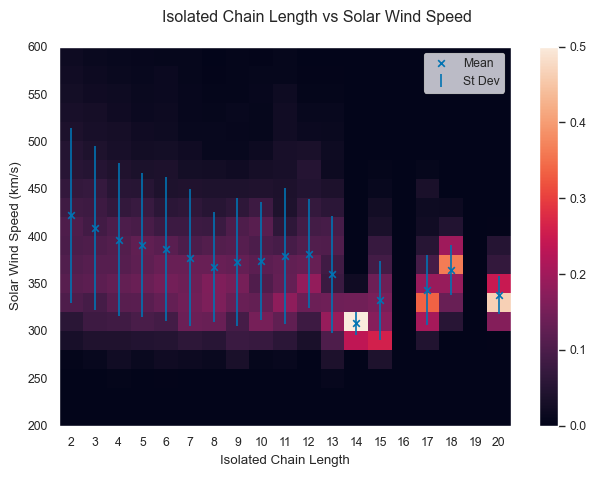

In [60]:
# GERG chain lengths vs flow speed
x = np.where(sophie80onsetdf['GERG']==1)[0]
y = np.where(sophie80onsetdf['Flag']==0)[0]
indices_onsets =np.intersect1d(x,y)
s = np.zeros(len(sophie80onsetdf))
s[indices_onsets] = True
s = pd.Series(s.astype(bool))
co = (~s).cumsum()[s].value_counts().to_list()
co = [i+1 for i in co]
y, x = np.histogram(co, bins=np.arange(2,np.max(co)+2,1))
x_edges = x - 0.5
x = x[:-1]
y_edges = np.arange(200,1001,25)

valuehist = []
valuemean = []
valuestd = []

for i in range(len(x)):
    if y[i] == 0:
        valuehist.append(np.zeros_like(y_edges[:-1]))
        valuemean.append(np.nan)
        valuestd.append(np.nan)

    else:

        len_repeat = x[i]

        index_repeat = np.where(((~s).cumsum()[s].value_counts()+1)==len_repeat)[0]

        valueloop = np.array([])

        for j in index_repeat:
            start = np.where((~s).cumsum()[s]==(~s).cumsum()[s].value_counts().index[j])[0][0]
            stop = start + (len_repeat - 1)
            sophieindicesstart = (~s).cumsum()[s][start:stop].index[0]
            sophieindicesstop = (~s).cumsum()[s][start:stop].index[-1] + 1
            onsetslice = sophie80onsetdf.iloc[sophieindicesstart-1:sophieindicesstop]
            tstart = onsetslice['Date_UTC'][onsetslice.index[0]]
            tend = onsetslice['Date_UTC'][onsetslice.index[-1]]+onsetslice['Duration'][onsetslice.index[-1]]

            valueloop = np.append(valueloop, omnidf[omnidf['Date_UTC'].between(tstart,tend)]['flow_speed'].to_numpy())
            # print('Yay! {} done!'.format(np.where(index_repeat==j)[0][0]))

        valueloophist = np.histogram(valueloop,bins=y_edges)[0]
        valueloophist = valueloophist/np.sum(valueloophist)
        valueloopmean = np.nanmean(valueloop)
        valueloopstd = np.nanstd(valueloop)

        valuehist.append(valueloophist)
        valuemean.append(valueloopmean)
        valuestd.append(valueloopstd)


fig, ax = plt.subplots()
colors = sns.color_palette("colorblind")
values = np.array(valuehist)

X,Y = np.meshgrid(x_edges,y_edges)
plot = ax.pcolormesh(X, Y, values.T,cmap=sns.color_palette("rocket",as_cmap=True), vmax=0.5)
ax.set_xlabel("Isolated Chain Length")
ax.set_ylabel("Solar Wind Speed (km/s)")
plt.colorbar(plot, ax=ax)
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.scatter(x,valuemean,label='Mean',marker='x')
ax.errorbar(x,valuemean,yerr=valuestd,label='St Dev',ls='None',marker='')
ax.legend(loc='upper right')
fig.suptitle('Isolated Chain Length vs Solar Wind Speed')
fig.tight_layout(pad=1)

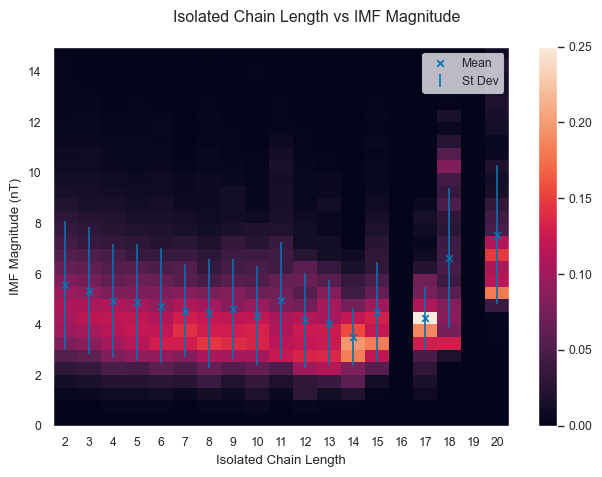

In [61]:
# GERG chain lengths vs IMF Magnitude
x = np.where(sophie80onsetdf['GERG']==1)[0]
y = np.where(sophie80onsetdf['Flag']==0)[0]
indices_onsets =np.intersect1d(x,y)
s = np.zeros(len(sophie80onsetdf))
s[indices_onsets] = True
s = pd.Series(s.astype(bool))
co = (~s).cumsum()[s].value_counts().to_list()
co = [i+1 for i in co]
y, x = np.histogram(co, bins=np.arange(2,np.max(co)+2,1))
x_edges = x - 0.5
x = x[:-1]
y_edges = np.arange(0,21)

valuehist = []
valuemean = []
valuestd = []

for i in range(len(x)):
    if y[i] == 0:
        valuehist.append(np.zeros_like(y_edges[:-1]))
        valuemean.append(np.nan)
        valuestd.append(np.nan)

    else:

        len_repeat = x[i]

        index_repeat = np.where(((~s).cumsum()[s].value_counts()+1)==len_repeat)[0]

        valueloop = np.array([])

        for j in index_repeat:
            start = np.where((~s).cumsum()[s]==(~s).cumsum()[s].value_counts().index[j])[0][0]
            stop = start + (len_repeat - 1)
            sophieindicesstart = (~s).cumsum()[s][start:stop].index[0]
            sophieindicesstop = (~s).cumsum()[s][start:stop].index[-1] + 1
            onsetslice = sophie80onsetdf.iloc[sophieindicesstart-1:sophieindicesstop]
            tstart = onsetslice['Date_UTC'][onsetslice.index[0]]
            tend = onsetslice['Date_UTC'][onsetslice.index[-1]]+onsetslice['Duration'][onsetslice.index[-1]]

            valueloop = np.append(valueloop, omnidf[omnidf['Date_UTC'].between(tstart,tend)]['F'].to_numpy())
            # print('Yay! {} done!'.format(np.where(index_repeat==j)[0][0]))

        valueloophist = np.histogram(valueloop,bins=y_edges)[0]
        valueloophist = valueloophist/np.sum(valueloophist)
        valueloopmean = np.nanmean(valueloop)
        valueloopstd = np.nanstd(valueloop)

        valuehist.append(valueloophist)
        valuemean.append(valueloopmean)
        valuestd.append(valueloopstd)


fig, ax = plt.subplots()
colors = sns.color_palette("colorblind")
values = np.array(valuehist)

X,Y = np.meshgrid(x_edges,y_edges)
plot = ax.pcolormesh(X, Y, values.T,cmap=sns.color_palette("rocket",as_cmap=True),vmax=0.25)
ax.set_xlabel("Isolated Chain Length")
ax.set_ylabel("IMF Magnitude (nT)")
plt.colorbar(plot, ax=ax)
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.scatter(x,valuemean,label='Mean',marker='x')
ax.errorbar(x,valuemean,yerr=valuestd,label='St Dev',ls='None',marker='')
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
ax.legend(loc='upper right')
fig.suptitle('Isolated Chain Length vs IMF Magnitude')
fig.tight_layout(pad=1)

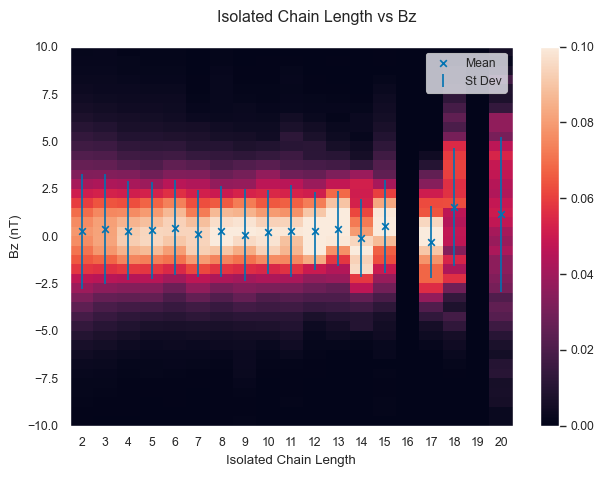

In [62]:
# GERG chain lengths vs Bz
x = np.where(sophie80onsetdf['GERG']==1)[0]
y = np.where(sophie80onsetdf['Flag']==0)[0]
indices_onsets =np.intersect1d(x,y)
s = np.zeros(len(sophie80onsetdf))
s[indices_onsets] = True
s = pd.Series(s.astype(bool))
co = (~s).cumsum()[s].value_counts().to_list()
co = [i+1 for i in co]
y, x = np.histogram(co, bins=np.arange(2,np.max(co)+2,1))
x_edges = x - 0.5
x = x[:-1]
y_edges = np.arange(-20,21)

valuehist = []
valuemean = []
valuestd = []

for i in range(len(x)):
    if y[i] == 0:
        valuehist.append(np.zeros_like(y_edges[:-1]))
        valuemean.append(np.nan)
        valuestd.append(np.nan)

    else:

        len_repeat = x[i]

        index_repeat = np.where(((~s).cumsum()[s].value_counts()+1)==len_repeat)[0]

        valueloop = np.array([])

        for j in index_repeat:
            start = np.where((~s).cumsum()[s]==(~s).cumsum()[s].value_counts().index[j])[0][0]
            stop = start + (len_repeat - 1)
            sophieindicesstart = (~s).cumsum()[s][start:stop].index[0]
            sophieindicesstop = (~s).cumsum()[s][start:stop].index[-1] + 1
            onsetslice = sophie80onsetdf.iloc[sophieindicesstart-1:sophieindicesstop]
            tstart = onsetslice['Date_UTC'][onsetslice.index[0]]
            tend = onsetslice['Date_UTC'][onsetslice.index[-1]]+onsetslice['Duration'][onsetslice.index[-1]]

            valueloop = np.append(valueloop, omnidf[omnidf['Date_UTC'].between(tstart,tend)]['BZ_GSM'].to_numpy())
            # print('Yay! {} done!'.format(np.where(index_repeat==j)[0][0]))

        valueloophist = np.histogram(valueloop,bins=y_edges)[0]
        valueloophist = valueloophist/np.sum(valueloophist)
        valueloopmean = np.nanmean(valueloop)
        valueloopstd = np.nanstd(valueloop)

        valuehist.append(valueloophist)
        valuemean.append(valueloopmean)
        valuestd.append(valueloopstd)


fig, ax = plt.subplots()
colors = sns.color_palette("colorblind")
values = np.array(valuehist)

X,Y = np.meshgrid(x_edges,y_edges)
plot = ax.pcolormesh(X, Y, values.T,cmap=sns.color_palette("rocket",as_cmap=True),vmax=0.1)
ax.set_xlabel("Isolated Chain Length")
ax.set_ylabel("Bz (nT)")
plt.colorbar(plot, ax=ax)
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.scatter(x,valuemean,label='Mean',marker='x')
ax.errorbar(x,valuemean,yerr=valuestd,label='St Dev',ls='None',marker='')
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
ax.legend(loc='upper right')
fig.suptitle('Isolated Chain Length vs Bz')
fig.tight_layout(pad=1)

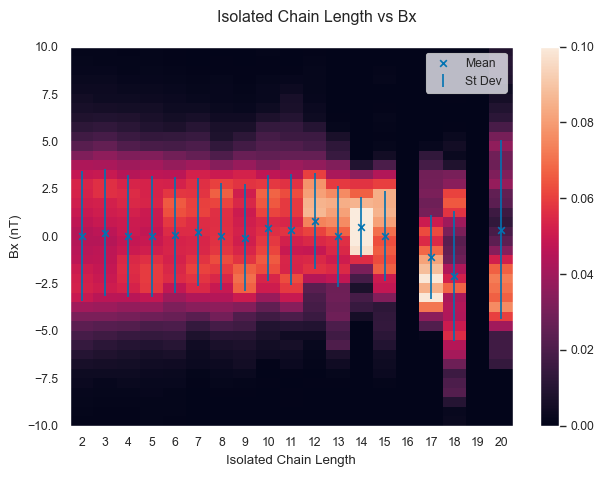

In [63]:
# GERG chain lengths vs Bx
x = np.where(sophie80onsetdf['GERG']==1)[0]
y = np.where(sophie80onsetdf['Flag']==0)[0]
indices_onsets =np.intersect1d(x,y)
s = np.zeros(len(sophie80onsetdf))
s[indices_onsets] = True
s = pd.Series(s.astype(bool))
co = (~s).cumsum()[s].value_counts().to_list()
co = [i+1 for i in co]
y, x = np.histogram(co, bins=np.arange(2,np.max(co)+2,1))
x_edges = x - 0.5
x = x[:-1]
y_edges = np.arange(-10,11)

valuehist = []
valuemean = []
valuestd = []

for i in range(len(x)):
    if y[i] == 0:
        valuehist.append(np.zeros_like(y_edges[:-1]))
        valuemean.append(np.nan)
        valuestd.append(np.nan)

    else:

        len_repeat = x[i]

        index_repeat = np.where(((~s).cumsum()[s].value_counts()+1)==len_repeat)[0]

        valueloop = np.array([])

        for j in index_repeat:
            start = np.where((~s).cumsum()[s]==(~s).cumsum()[s].value_counts().index[j])[0][0]
            stop = start + (len_repeat - 1)
            sophieindicesstart = (~s).cumsum()[s][start:stop].index[0]
            sophieindicesstop = (~s).cumsum()[s][start:stop].index[-1] + 1
            onsetslice = sophie80onsetdf.iloc[sophieindicesstart-1:sophieindicesstop]
            tstart = onsetslice['Date_UTC'][onsetslice.index[0]]
            tend = onsetslice['Date_UTC'][onsetslice.index[-1]]+onsetslice['Duration'][onsetslice.index[-1]]

            valueloop = np.append(valueloop, omnidf[omnidf['Date_UTC'].between(tstart,tend)]['BX_GSE'].to_numpy())
            # print('Yay! {} done!'.format(np.where(index_repeat==j)[0][0]))

        valueloophist = np.histogram(valueloop,bins=y_edges)[0]
        valueloophist = valueloophist/np.sum(valueloophist)
        valueloopmean = np.nanmean(valueloop)
        valueloopstd = np.nanstd(valueloop)

        valuehist.append(valueloophist)
        valuemean.append(valueloopmean)
        valuestd.append(valueloopstd)


fig, ax = plt.subplots()
colors = sns.color_palette("colorblind")
values = np.array(valuehist)

X,Y = np.meshgrid(x_edges,y_edges)
plot = ax.pcolormesh(X, Y, values.T,cmap=sns.color_palette("rocket",as_cmap=True),vmax=0.1)
ax.set_xlabel("Isolated Chain Length")
ax.set_ylabel("Bx (nT)")
plt.colorbar(plot, ax=ax)
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.scatter(x,valuemean,label='Mean',marker='x')
ax.errorbar(x,valuemean,yerr=valuestd,label='St Dev',ls='None',marker='')
ax.legend(loc='upper right')
fig.suptitle('Isolated Chain Length vs Bx')
fig.tight_layout(pad=1)

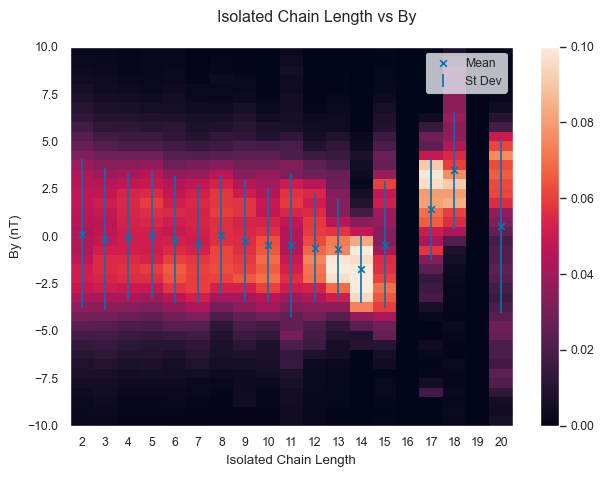

In [64]:
# GERG chain lengths vs By
x = np.where(sophie80onsetdf['GERG']==1)[0]
y = np.where(sophie80onsetdf['Flag']==0)[0]
indices_onsets =np.intersect1d(x,y)
s = np.zeros(len(sophie80onsetdf))
s[indices_onsets] = True
s = pd.Series(s.astype(bool))
co = (~s).cumsum()[s].value_counts().to_list()
co = [i+1 for i in co]
y, x = np.histogram(co, bins=np.arange(2,np.max(co)+2,1))
x_edges = x - 0.5
x = x[:-1]
y_edges = np.arange(-10,11)

valuehist = []
valuemean = []
valuestd = []

for i in range(len(x)):
    if y[i] == 0:
        valuehist.append(np.zeros_like(y_edges[:-1]))
        valuemean.append(np.nan)
        valuestd.append(np.nan)

    else:

        len_repeat = x[i]

        index_repeat = np.where(((~s).cumsum()[s].value_counts()+1)==len_repeat)[0]

        valueloop = np.array([])

        for j in index_repeat:
            start = np.where((~s).cumsum()[s]==(~s).cumsum()[s].value_counts().index[j])[0][0]
            stop = start + (len_repeat - 1)
            sophieindicesstart = (~s).cumsum()[s][start:stop].index[0]
            sophieindicesstop = (~s).cumsum()[s][start:stop].index[-1] + 1
            onsetslice = sophie80onsetdf.iloc[sophieindicesstart-1:sophieindicesstop]
            tstart = onsetslice['Date_UTC'][onsetslice.index[0]]
            tend = onsetslice['Date_UTC'][onsetslice.index[-1]]+onsetslice['Duration'][onsetslice.index[-1]]

            valueloop = np.append(valueloop, omnidf[omnidf['Date_UTC'].between(tstart,tend)]['BY_GSM'].to_numpy())
            # print('Yay! {} done!'.format(np.where(index_repeat==j)[0][0]))

        valueloophist = np.histogram(valueloop,bins=y_edges)[0]
        valueloophist = valueloophist/np.sum(valueloophist)
        valueloopmean = np.nanmean(valueloop)
        valueloopstd = np.nanstd(valueloop)

        valuehist.append(valueloophist)
        valuemean.append(valueloopmean)
        valuestd.append(valueloopstd)


fig, ax = plt.subplots()
colors = sns.color_palette("colorblind")
values = np.array(valuehist)

X,Y = np.meshgrid(x_edges,y_edges)
plot = ax.pcolormesh(X, Y, values.T,cmap=sns.color_palette("rocket",as_cmap=True),vmax=0.1)
ax.set_xlabel("Isolated Chain Length")
ax.set_ylabel("By (nT)")
plt.colorbar(plot, ax=ax)
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.scatter(x,valuemean,label='Mean',marker='x')
ax.errorbar(x,valuemean,yerr=valuestd,label='St Dev',ls='None',marker='')
ax.legend(loc='upper right')
fig.suptitle('Isolated Chain Length vs By')
fig.tight_layout(pad=1)

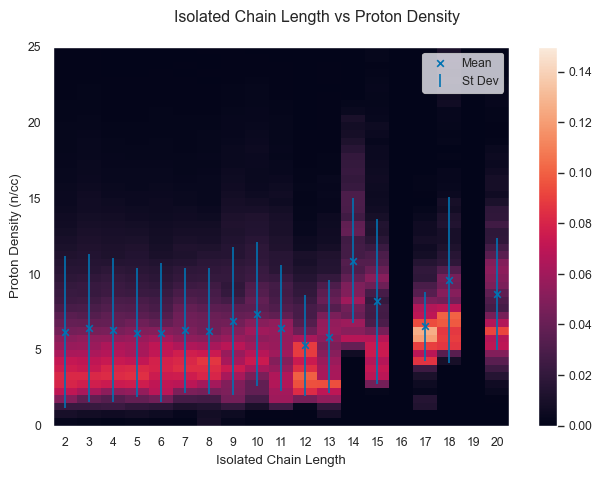

In [65]:
# GERG chain lengths vs Proton Density
x = np.where(sophie80onsetdf['GERG']==1)[0]
y = np.where(sophie80onsetdf['Flag']==0)[0]
indices_onsets =np.intersect1d(x,y)
s = np.zeros(len(sophie80onsetdf))
s[indices_onsets] = True
s = pd.Series(s.astype(bool))
co = (~s).cumsum()[s].value_counts().to_list()
co = [i+1 for i in co]
y, x = np.histogram(co, bins=np.arange(2,np.max(co)+2,1))
x_edges = x - 0.5
x = x[:-1]
y_edges = np.arange(0,26)

valuehist = []
valuemean = []
valuestd = []

for i in range(len(x)):
    if y[i] == 0:
        valuehist.append(np.zeros_like(y_edges[:-1]))
        valuemean.append(np.nan)
        valuestd.append(np.nan)

    else:

        len_repeat = x[i]

        index_repeat = np.where(((~s).cumsum()[s].value_counts()+1)==len_repeat)[0]

        valueloop = np.array([])

        for j in index_repeat:
            start = np.where((~s).cumsum()[s]==(~s).cumsum()[s].value_counts().index[j])[0][0]
            stop = start + (len_repeat - 1)
            sophieindicesstart = (~s).cumsum()[s][start:stop].index[0]
            sophieindicesstop = (~s).cumsum()[s][start:stop].index[-1] + 1
            onsetslice = sophie80onsetdf.iloc[sophieindicesstart-1:sophieindicesstop]
            tstart = onsetslice['Date_UTC'][onsetslice.index[0]]
            tend = onsetslice['Date_UTC'][onsetslice.index[-1]]+onsetslice['Duration'][onsetslice.index[-1]]

            valueloop = np.append(valueloop, omnidf[omnidf['Date_UTC'].between(tstart,tend)]['proton_density'].to_numpy())
            # print('Yay! {} done!'.format(np.where(index_repeat==j)[0][0]))

        valueloophist = np.histogram(valueloop,bins=y_edges)[0]
        valueloophist = valueloophist/np.sum(valueloophist)
        valueloopmean = np.nanmean(valueloop)
        valueloopstd = np.nanstd(valueloop)

        valuehist.append(valueloophist)
        valuemean.append(valueloopmean)
        valuestd.append(valueloopstd)


fig, ax = plt.subplots()
colors = sns.color_palette("colorblind")
values = np.array(valuehist)

X,Y = np.meshgrid(x_edges,y_edges)
plot = ax.pcolormesh(X, Y, values.T,cmap=sns.color_palette("rocket",as_cmap=True),vmax=0.15)
ax.set_xlabel("Isolated Chain Length")
ax.set_ylabel("Proton Density (n/cc)")
plt.colorbar(plot, ax=ax)
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.scatter(x,valuemean,label='Mean',marker='x')
ax.errorbar(x,valuemean,yerr=valuestd,label='St Dev',ls='None',marker='')
ax.legend(loc='upper right')
fig.suptitle('Isolated Chain Length vs Proton Density')
fig.tight_layout(pad=1)

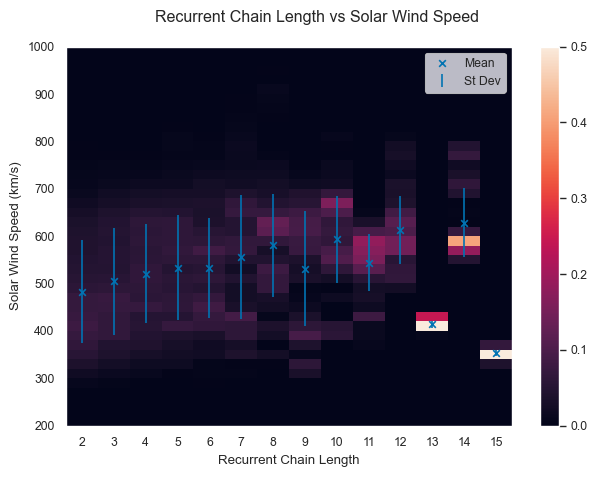

In [66]:
# ERER chain lengths vs flow speed
x = np.where(sophie80onsetdf['ERER']==1)[0]
y = np.where(sophie80onsetdf['Flag']==0)[0]
indices_onsets =np.intersect1d(x,y)
s = np.zeros(len(sophie80onsetdf))
s[indices_onsets] = True
s = pd.Series(s.astype(bool))
co = (~s).cumsum()[s].value_counts().to_list()
co = [i+1 for i in co]
y, x = np.histogram(co, bins=np.arange(2,np.max(co)+2,1))
x_edges = x - 0.5
x = x[:-1]
y_edges = np.arange(200,1001,25)

valuehist = []
valuemean = []
valuestd = []

for i in range(len(x)):
    if y[i] == 0:
        valuehist.append(np.zeros_like(y_edges[:-1]))
        valuemean.append(np.nan)
        valuestd.append(np.nan)

    else:

        len_repeat = x[i]

        index_repeat = np.where(((~s).cumsum()[s].value_counts()+1)==len_repeat)[0]

        valueloop = np.array([])

        for j in index_repeat:
            start = np.where((~s).cumsum()[s]==(~s).cumsum()[s].value_counts().index[j])[0][0]
            stop = start + (len_repeat - 1)
            sophieindicesstart = (~s).cumsum()[s][start:stop].index[0]
            sophieindicesstop = (~s).cumsum()[s][start:stop].index[-1] + 1
            onsetslice = sophie80onsetdf.iloc[sophieindicesstart-1:sophieindicesstop]
            tstart = onsetslice['Date_UTC'][onsetslice.index[0]]
            tend = onsetslice['Date_UTC'][onsetslice.index[-1]]+onsetslice['Duration'][onsetslice.index[-1]]

            valueloop = np.append(valueloop, omnidf[omnidf['Date_UTC'].between(tstart,tend)]['flow_speed'].to_numpy())
            # print('Yay! {} done!'.format(np.where(index_repeat==j)[0][0]))

        valueloophist = np.histogram(valueloop,bins=y_edges)[0]
        valueloophist = valueloophist/np.sum(valueloophist)
        valueloopmean = np.nanmean(valueloop)
        valueloopstd = np.nanstd(valueloop)

        valuehist.append(valueloophist)
        valuemean.append(valueloopmean)
        valuestd.append(valueloopstd)


fig, ax = plt.subplots()
colors = sns.color_palette("colorblind")
values = np.array(valuehist)

X,Y = np.meshgrid(x_edges,y_edges)
plot = ax.pcolormesh(X, Y, values.T,cmap=sns.color_palette("rocket",as_cmap=True),vmax=0.5)
ax.set_xlabel("Recurrent Chain Length")
ax.set_ylabel("Solar Wind Speed (km/s)")
plt.colorbar(plot, ax=ax)
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.scatter(x,valuemean,label='Mean',marker='x')
ax.errorbar(x,valuemean,yerr=valuestd,label='St Dev',ls='None',marker='')
ax.legend(loc='upper right')
fig.suptitle('Recurrent Chain Length vs Solar Wind Speed')
fig.tight_layout(pad=1)

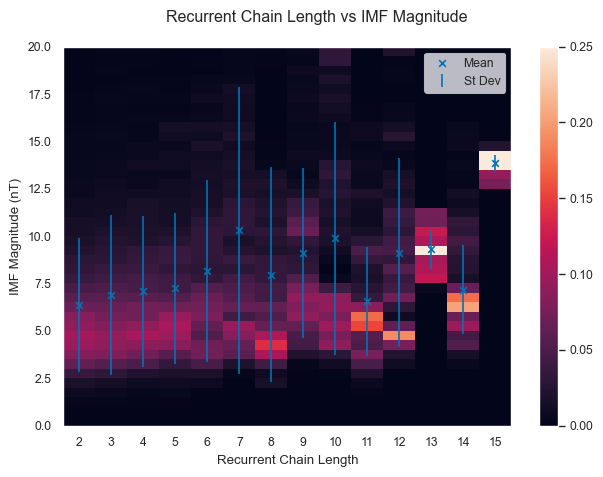

In [67]:
# ERER chain lengths vs IMF Magnitude
x = np.where(sophie80onsetdf['ERER']==1)[0]
y = np.where(sophie80onsetdf['Flag']==0)[0]
indices_onsets =np.intersect1d(x,y)
s = np.zeros(len(sophie80onsetdf))
s[indices_onsets] = True
s = pd.Series(s.astype(bool))
co = (~s).cumsum()[s].value_counts().to_list()
co = [i+1 for i in co]
y, x = np.histogram(co, bins=np.arange(2,np.max(co)+2,1))
x_edges = x - 0.5
x = x[:-1]
y_edges = np.arange(0,21)

valuehist = []
valuemean = []
valuestd = []

for i in range(len(x)):
    if y[i] == 0:
        valuehist.append(np.zeros_like(y_edges[:-1]))
        valuemean.append(np.nan)
        valuestd.append(np.nan)

    else:

        len_repeat = x[i]

        index_repeat = np.where(((~s).cumsum()[s].value_counts()+1)==len_repeat)[0]

        valueloop = np.array([])

        for j in index_repeat:
            start = np.where((~s).cumsum()[s]==(~s).cumsum()[s].value_counts().index[j])[0][0]
            stop = start + (len_repeat - 1)
            sophieindicesstart = (~s).cumsum()[s][start:stop].index[0]
            sophieindicesstop = (~s).cumsum()[s][start:stop].index[-1] + 1
            onsetslice = sophie80onsetdf.iloc[sophieindicesstart-1:sophieindicesstop]
            tstart = onsetslice['Date_UTC'][onsetslice.index[0]]
            tend = onsetslice['Date_UTC'][onsetslice.index[-1]]+onsetslice['Duration'][onsetslice.index[-1]]

            valueloop = np.append(valueloop, omnidf[omnidf['Date_UTC'].between(tstart,tend)]['F'].to_numpy())
            # print('Yay! {} done!'.format(np.where(index_repeat==j)[0][0]))

        valueloophist = np.histogram(valueloop,bins=y_edges)[0]
        valueloophist = valueloophist/np.sum(valueloophist)
        valueloopmean = np.nanmean(valueloop)
        valueloopstd = np.nanstd(valueloop)

        valuehist.append(valueloophist)
        valuemean.append(valueloopmean)
        valuestd.append(valueloopstd)


fig, ax = plt.subplots()
colors = sns.color_palette("colorblind")
values = np.array(valuehist)

X,Y = np.meshgrid(x_edges,y_edges)
plot = ax.pcolormesh(X, Y, values.T,cmap=sns.color_palette("rocket",as_cmap=True),vmax=0.25)
ax.set_xlabel("Recurrent Chain Length")
ax.set_ylabel("IMF Magnitude (nT)")
plt.colorbar(plot, ax=ax)
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.scatter(x,valuemean,label='Mean',marker='x')
ax.errorbar(x,valuemean,yerr=valuestd,label='St Dev',ls='None',marker='')
ax.yaxis.set_major_locator(ticker.MultipleLocator(2))
ax.legend(loc='upper right')
fig.suptitle('Recurrent Chain Length vs IMF Magnitude')
fig.tight_layout(pad=1)

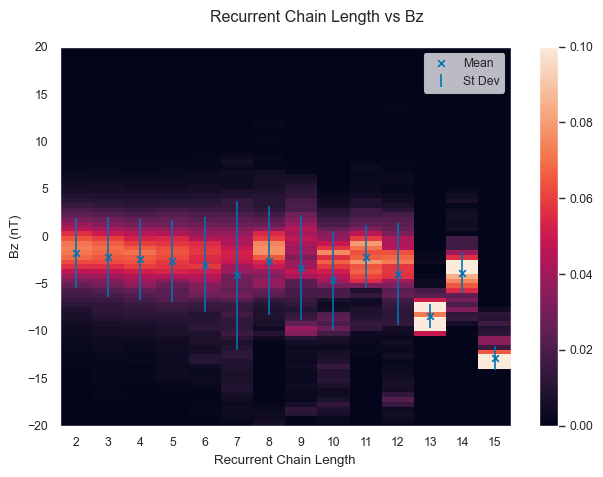

In [68]:
# ERER chain lengths vs Bz Magnitude
x = np.where(sophie80onsetdf['ERER']==1)[0]
y = np.where(sophie80onsetdf['Flag']==0)[0]
indices_onsets =np.intersect1d(x,y)
s = np.zeros(len(sophie80onsetdf))
s[indices_onsets] = True
s = pd.Series(s.astype(bool))
co = (~s).cumsum()[s].value_counts().to_list()
co = [i+1 for i in co]
y, x = np.histogram(co, bins=np.arange(2,np.max(co)+2,1))
x_edges = x - 0.5
x = x[:-1]
y_edges = np.arange(-20,21)

valuehist = []
valuemean = []
valuestd = []

for i in range(len(x)):
    if y[i] == 0:
        valuehist.append(np.zeros_like(y_edges[:-1]))
        valuemean.append(np.nan)
        valuestd.append(np.nan)

    else:

        len_repeat = x[i]

        index_repeat = np.where(((~s).cumsum()[s].value_counts()+1)==len_repeat)[0]

        valueloop = np.array([])

        for j in index_repeat:
            start = np.where((~s).cumsum()[s]==(~s).cumsum()[s].value_counts().index[j])[0][0]
            stop = start + (len_repeat - 1)
            sophieindicesstart = (~s).cumsum()[s][start:stop].index[0]
            sophieindicesstop = (~s).cumsum()[s][start:stop].index[-1] + 1
            onsetslice = sophie80onsetdf.iloc[sophieindicesstart-1:sophieindicesstop]
            tstart = onsetslice['Date_UTC'][onsetslice.index[0]]
            tend = onsetslice['Date_UTC'][onsetslice.index[-1]]+onsetslice['Duration'][onsetslice.index[-1]]

            valueloop = np.append(valueloop, omnidf[omnidf['Date_UTC'].between(tstart,tend)]['BZ_GSM'].to_numpy())
            # print('Yay! {} done!'.format(np.where(index_repeat==j)[0][0]))

        valueloophist = np.histogram(valueloop,bins=y_edges)[0]
        valueloophist = valueloophist/np.sum(valueloophist)
        valueloopmean = np.nanmean(valueloop)
        valueloopstd = np.nanstd(valueloop)

        valuehist.append(valueloophist)
        valuemean.append(valueloopmean)
        valuestd.append(valueloopstd)


fig, ax = plt.subplots()
colors = sns.color_palette("colorblind")
values = np.array(valuehist)

X,Y = np.meshgrid(x_edges,y_edges)
plot = ax.pcolormesh(X, Y, values.T,cmap=sns.color_palette("rocket",as_cmap=True),vmax=0.1)
ax.set_xlabel("Recurrent Chain Length")
ax.set_ylabel("Bz (nT)")
plt.colorbar(plot, ax=ax)
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.scatter(x,valuemean,label='Mean',marker='x')
ax.errorbar(x,valuemean,yerr=valuestd,label='St Dev',ls='None',marker='')
ax.legend(loc='upper right')
fig.suptitle('Recurrent Chain Length vs Bz')
fig.tight_layout(pad=1)

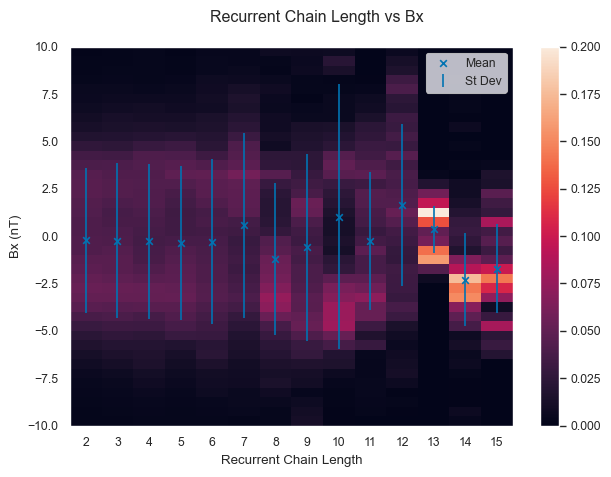

In [69]:
# GERG chain lengths vs Bx
x = np.where(sophie80onsetdf['ERER']==1)[0]
y = np.where(sophie80onsetdf['Flag']==0)[0]
indices_onsets =np.intersect1d(x,y)
s = np.zeros(len(sophie80onsetdf))
s[indices_onsets] = True
s = pd.Series(s.astype(bool))
co = (~s).cumsum()[s].value_counts().to_list()
co = [i+1 for i in co]
y, x = np.histogram(co, bins=np.arange(2,np.max(co)+2,1))
x_edges = x - 0.5
x = x[:-1]
y_edges = np.arange(-10,11)

valuehist = []
valuemean = []
valuestd = []

for i in range(len(x)):
    if y[i] == 0:
        valuehist.append(np.zeros_like(y_edges[:-1]))
        valuemean.append(np.nan)
        valuestd.append(np.nan)

    else:

        len_repeat = x[i]

        index_repeat = np.where(((~s).cumsum()[s].value_counts()+1)==len_repeat)[0]

        valueloop = np.array([])

        for j in index_repeat:
            start = np.where((~s).cumsum()[s]==(~s).cumsum()[s].value_counts().index[j])[0][0]
            stop = start + (len_repeat - 1)
            sophieindicesstart = (~s).cumsum()[s][start:stop].index[0]
            sophieindicesstop = (~s).cumsum()[s][start:stop].index[-1] + 1
            onsetslice = sophie80onsetdf.iloc[sophieindicesstart-1:sophieindicesstop]
            tstart = onsetslice['Date_UTC'][onsetslice.index[0]]
            tend = onsetslice['Date_UTC'][onsetslice.index[-1]]+onsetslice['Duration'][onsetslice.index[-1]]

            valueloop = np.append(valueloop, omnidf[omnidf['Date_UTC'].between(tstart,tend)]['BX_GSE'].to_numpy())
            # print('Yay! {} done!'.format(np.where(index_repeat==j)[0][0]))

        valueloophist = np.histogram(valueloop,bins=y_edges)[0]
        valueloophist = valueloophist/np.sum(valueloophist)
        valueloopmean = np.nanmean(valueloop)
        valueloopstd = np.nanstd(valueloop)

        valuehist.append(valueloophist)
        valuemean.append(valueloopmean)
        valuestd.append(valueloopstd)


fig, ax = plt.subplots()
colors = sns.color_palette("colorblind")
values = np.array(valuehist)

X,Y = np.meshgrid(x_edges,y_edges)
plot = ax.pcolormesh(X, Y, values.T,cmap=sns.color_palette("rocket",as_cmap=True),vmax=0.2)
ax.set_xlabel("Recurrent Chain Length")
ax.set_ylabel("Bx (nT)")
plt.colorbar(plot, ax=ax)
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.scatter(x,valuemean,label='Mean',marker='x')
ax.errorbar(x,valuemean,yerr=valuestd,label='St Dev',ls='None',marker='')
ax.legend(loc='upper right')
fig.suptitle('Recurrent Chain Length vs Bx')
fig.tight_layout(pad=1)

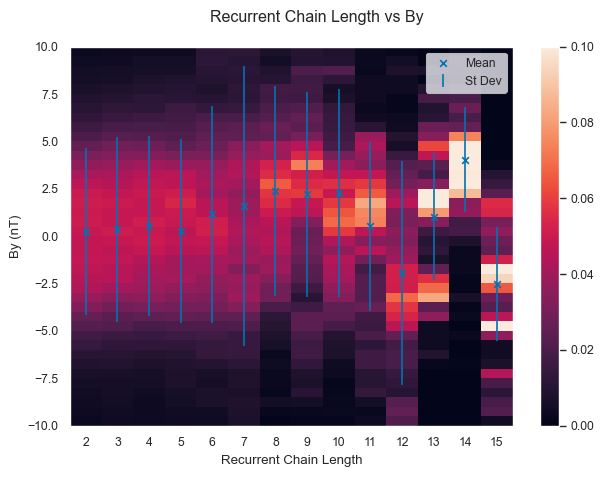

In [70]:
# GERG chain lengths vs By
x = np.where(sophie80onsetdf['ERER']==1)[0]
y = np.where(sophie80onsetdf['Flag']==0)[0]
indices_onsets =np.intersect1d(x,y)
s = np.zeros(len(sophie80onsetdf))
s[indices_onsets] = True
s = pd.Series(s.astype(bool))
co = (~s).cumsum()[s].value_counts().to_list()
co = [i+1 for i in co]
y, x = np.histogram(co, bins=np.arange(2,np.max(co)+2,1))
x_edges = x - 0.5
x = x[:-1]
y_edges = np.arange(-10,11)

valuehist = []
valuemean = []
valuestd = []

for i in range(len(x)):
    if y[i] == 0:
        valuehist.append(np.zeros_like(y_edges[:-1]))
        valuemean.append(np.nan)
        valuestd.append(np.nan)

    else:

        len_repeat = x[i]

        index_repeat = np.where(((~s).cumsum()[s].value_counts()+1)==len_repeat)[0]

        valueloop = np.array([])

        for j in index_repeat:
            start = np.where((~s).cumsum()[s]==(~s).cumsum()[s].value_counts().index[j])[0][0]
            stop = start + (len_repeat - 1)
            sophieindicesstart = (~s).cumsum()[s][start:stop].index[0]
            sophieindicesstop = (~s).cumsum()[s][start:stop].index[-1] + 1
            onsetslice = sophie80onsetdf.iloc[sophieindicesstart-1:sophieindicesstop]
            tstart = onsetslice['Date_UTC'][onsetslice.index[0]]
            tend = onsetslice['Date_UTC'][onsetslice.index[-1]]+onsetslice['Duration'][onsetslice.index[-1]]

            valueloop = np.append(valueloop, omnidf[omnidf['Date_UTC'].between(tstart,tend)]['BY_GSM'].to_numpy())
            # print('Yay! {} done!'.format(np.where(index_repeat==j)[0][0]))

        valueloophist = np.histogram(valueloop,bins=y_edges)[0]
        valueloophist = valueloophist/np.sum(valueloophist)
        valueloopmean = np.nanmean(valueloop)
        valueloopstd = np.nanstd(valueloop)

        valuehist.append(valueloophist)
        valuemean.append(valueloopmean)
        valuestd.append(valueloopstd)


fig, ax = plt.subplots()
colors = sns.color_palette("colorblind")
values = np.array(valuehist)

X,Y = np.meshgrid(x_edges,y_edges)
plot = ax.pcolormesh(X, Y, values.T,cmap=sns.color_palette("rocket",as_cmap=True),vmax=0.1)
ax.set_xlabel("Recurrent Chain Length")
ax.set_ylabel("By (nT)")
plt.colorbar(plot, ax=ax)
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.scatter(x,valuemean,label='Mean',marker='x')
ax.errorbar(x,valuemean,yerr=valuestd,label='St Dev',ls='None',marker='')
ax.legend(loc='upper right')
fig.suptitle('Recurrent Chain Length vs By')
fig.tight_layout(pad=1)

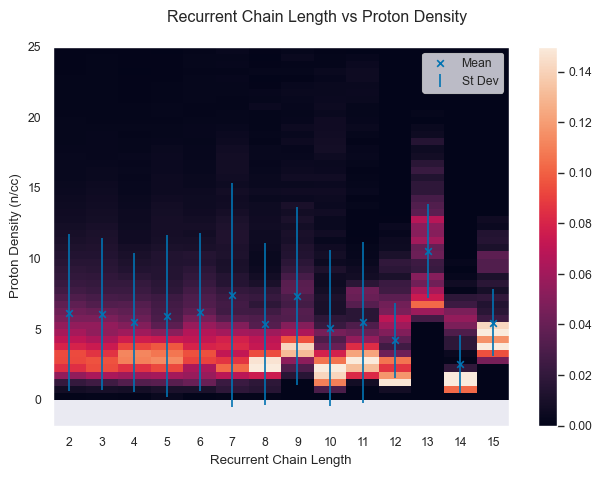

In [71]:
# GERG chain lengths vs Proton Density
x = np.where(sophie80onsetdf['ERER']==1)[0]
y = np.where(sophie80onsetdf['Flag']==0)[0]
indices_onsets =np.intersect1d(x,y)
s = np.zeros(len(sophie80onsetdf))
s[indices_onsets] = True
s = pd.Series(s.astype(bool))
co = (~s).cumsum()[s].value_counts().to_list()
co = [i+1 for i in co]
y, x = np.histogram(co, bins=np.arange(2,np.max(co)+2,1))
x_edges = x - 0.5
x = x[:-1]
y_edges = np.arange(0,26)

valuehist = []
valuemean = []
valuestd = []

for i in range(len(x)):
    if y[i] == 0:
        valuehist.append(np.zeros_like(y_edges[:-1]))
        valuemean.append(np.nan)
        valuestd.append(np.nan)

    else:

        len_repeat = x[i]

        index_repeat = np.where(((~s).cumsum()[s].value_counts()+1)==len_repeat)[0]

        valueloop = np.array([])

        for j in index_repeat:
            start = np.where((~s).cumsum()[s]==(~s).cumsum()[s].value_counts().index[j])[0][0]
            stop = start + (len_repeat - 1)
            sophieindicesstart = (~s).cumsum()[s][start:stop].index[0]
            sophieindicesstop = (~s).cumsum()[s][start:stop].index[-1] + 1
            onsetslice = sophie80onsetdf.iloc[sophieindicesstart-1:sophieindicesstop]
            tstart = onsetslice['Date_UTC'][onsetslice.index[0]]
            tend = onsetslice['Date_UTC'][onsetslice.index[-1]]+onsetslice['Duration'][onsetslice.index[-1]]

            valueloop = np.append(valueloop, omnidf[omnidf['Date_UTC'].between(tstart,tend)]['proton_density'].to_numpy())
            # print('Yay! {} done!'.format(np.where(index_repeat==j)[0][0]))

        valueloophist = np.histogram(valueloop,bins=y_edges)[0]
        valueloophist = valueloophist/np.sum(valueloophist)
        valueloopmean = np.nanmean(valueloop)
        valueloopstd = np.nanstd(valueloop)

        valuehist.append(valueloophist)
        valuemean.append(valueloopmean)
        valuestd.append(valueloopstd)


fig, ax = plt.subplots()
colors = sns.color_palette("colorblind")
values = np.array(valuehist)

X,Y = np.meshgrid(x_edges,y_edges)
plot = ax.pcolormesh(X, Y, values.T,cmap=sns.color_palette("rocket",as_cmap=True),vmax=0.15)
ax.set_xlabel("Recurrent Chain Length")
ax.set_ylabel("Proton Density (n/cc)")
plt.colorbar(plot, ax=ax)
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.scatter(x,valuemean,label='Mean',marker='x')
ax.errorbar(x,valuemean,yerr=valuestd,label='St Dev',ls='None',marker='')
ax.legend(loc='upper right')
fig.suptitle('Recurrent Chain Length vs Proton Density')
fig.tight_layout(pad=1)